# MACHINE LEARNING I
# 
# LAB ASSIGNMENT II: TIME SERIES

## Authors:

- **Alberto García Martín**: 202309188@alu.comillas.edu

- **Jorge Peralta Fernández-Revuelta**: jperalta@alu.comillas.edu

- **Juan López Segura**: juanls@alu.comillas.edu

In this lab assignment, we will analyze the UnemploymentSpain.dat dataset and extract conclusions, performing several time series methods properly explained.

---

In [182]:
# For more information, check https://www.machinelearningplus.com/time-series/time-series-analysis-python/ 
### Load libraries ###
# interactive plotting
#%matplotlib inline
#%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
sns.set()
#Define figure sizes
plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from dateutil.parser import parse 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

# Machine Learning libraries
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict
import scipy as sp

# Others
import math
from mltools import forecast_tools as FT
import scipy.stats as st
from mltools import model_tools as MT
from neuralsens import partial_derivatives as ns
from mltools import regression_tools as RT

---
## 1. Read the dataset

In [88]:
# Import data
df = pd.read_csv('UnemploymentSpain.dat', parse_dates=['DATE'], dayfirst=True, sep='\t', index_col='DATE')
df

,TOTAL
DATE,
2001-01-01,2017389
2001-02-01,1993273
2001-03-01,1981006
2001-04-01,1910453
2001-05-01,1898285
...,...
2023-06-01,2688842
2023-07-01,2677874
2023-08-01,2702700


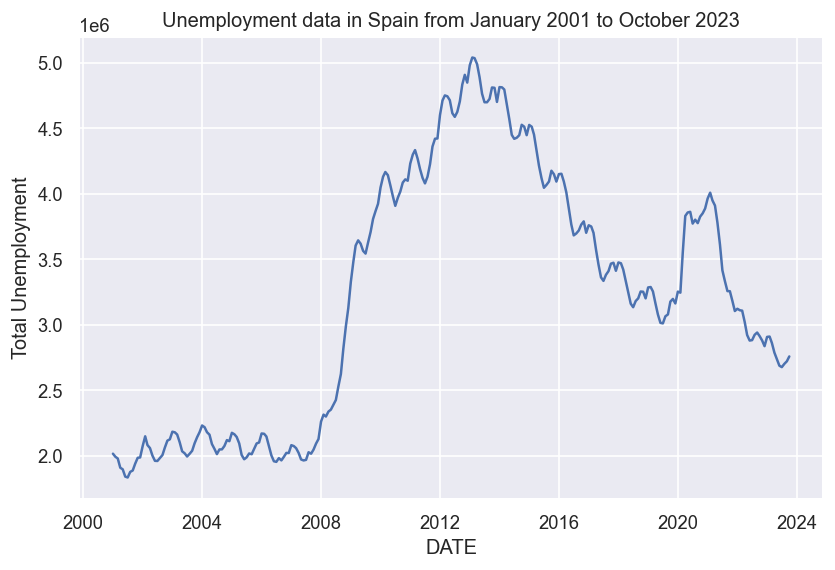

In [271]:
# Plotting a time series
fig, ax = plt.subplots()

ax.plot('TOTAL', data=df)
ax.set(title='Unemployment data in Spain from January 2001 to October 2023', xlabel='DATE', ylabel='Total Unemployment')


plt.show()

In [90]:
y = df
prop_train=0.88

## Divide the data into training and test sets SEQUENTIALY -------------------------------------
y_train = y.iloc[0:round(0.64*y.shape[0])]
y_test = y.iloc[round(0.64*y.shape[0])+1:round(0.8*y.shape[0])]

y_train2 = y.iloc[0:round(prop_train*y.shape[0])] #Si funciona mal, cambiar por 0.9
y_test2 = y.iloc[round(prop_train*y.shape[0])+1:round(y.shape[0])]

y_train.head()

,TOTAL
DATE,
2001-01-01,2017389
2001-02-01,1993273
2001-03-01,1981006
2001-04-01,1910453
2001-05-01,1898285


Se divide el dataset en dos subconjuntos de entrenaimento y test. Esto es debido a que el último 20% corresponde al COVID, y si se utilizase un 80/20 sería el conjunto de test el del COVID, dando una sensación falsa de que el modelo es malo, y sin poder captar el verdadero comportamiento de la pandemia. Por ello, si se quieren entrenar modelos, se usan primero los datos sin COVID con una proporción aproximada de 80/20 (en el total, una relación 64/16). Con ello, se pretende conseguir un modelo que ajuste bien la serie temporal sin comportamientos anómalos y con menos riesgo de sobreajuste que si únicamente se utilizase entrenamiento, ya que se puede comprobar su comportamiento en el test.

Tras eso, se estudia de nuevo la serie en una proporción 88/12 (para que el test no sea prácticamente del COVID, pero haya algún comportamiento raro en el test para observar diferencias entre modelos) y, basándonos en un modelo que sabemos que no tiene un gran sobreajuste y es decente en predicciones y métricas, se realizan los reajustes necesarios para estos nuevos datos, con la intención de que sea un modelo decente en sus predicciones y sin que peque de sobreajuste.

---
### Identification process

Se comienza trabajando únicamente con el subconjunto de entrenamiento.

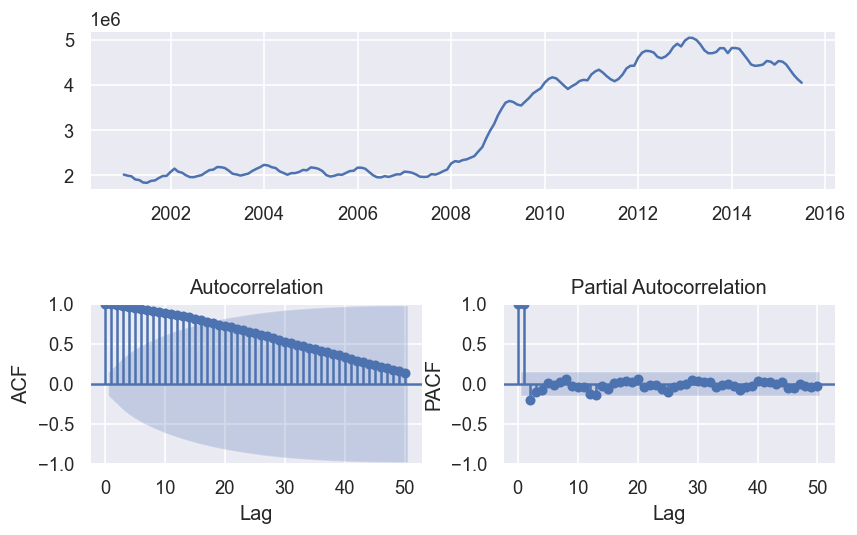

In [91]:
# ACF and PACF of the time series -> identify significant lags and order
FT.ts_display(y_train,lags=50)

#### 2. Stabilize the variance (if needed)

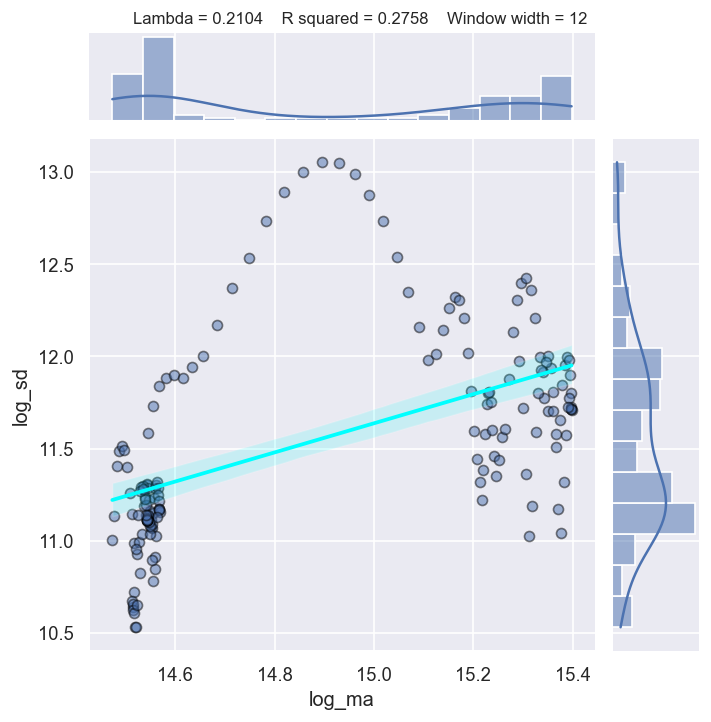

In [92]:
# Box-Cox transformation
lmbda = FT.boxcox_lambda_plot(y_train, window_width=12)

En este caso se aprecia una relación entre ambas, pero una no lineal. Por ello, ambas opciones podrían ser correctas, pero decidimos aplicar Box-Cox ya que creemos que puede ayudar ligeramente, y en los modelos no se observan cambios muy relevantes.

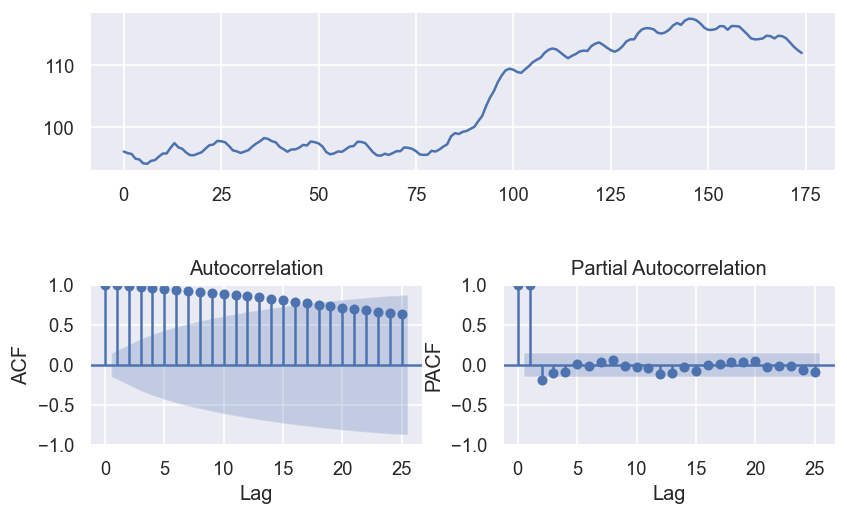

In [93]:
# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    z = st.boxcox(y_train.values[:,0],   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df.values[:,0] - min(df.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=y_train.columns.values.tolist())
else:
    z = y_train

# Plot transformed data
FT.ts_display(z)

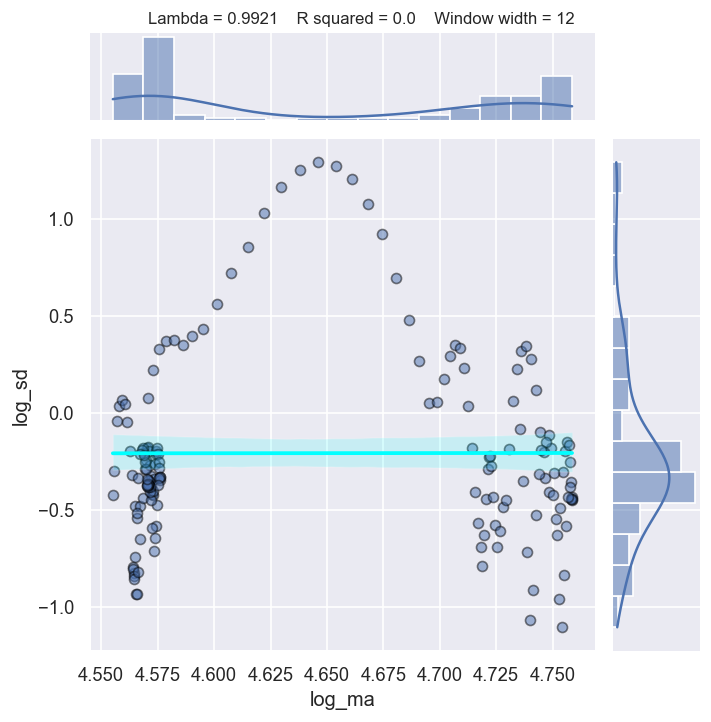

0.9921306069971116

In [94]:
#Check Box Cox of transformed series
FT.boxcox_lambda_plot(z, window_width=12)

#### 3. Analyze stationarity 

In [95]:
# Alternative test - Augmented Dickey Fuller Test
result = adfuller(z.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.391117
p-value: 0.586527
Critical Values:
	1%: -3.472
	5%: -2.880
	10%: -2.576


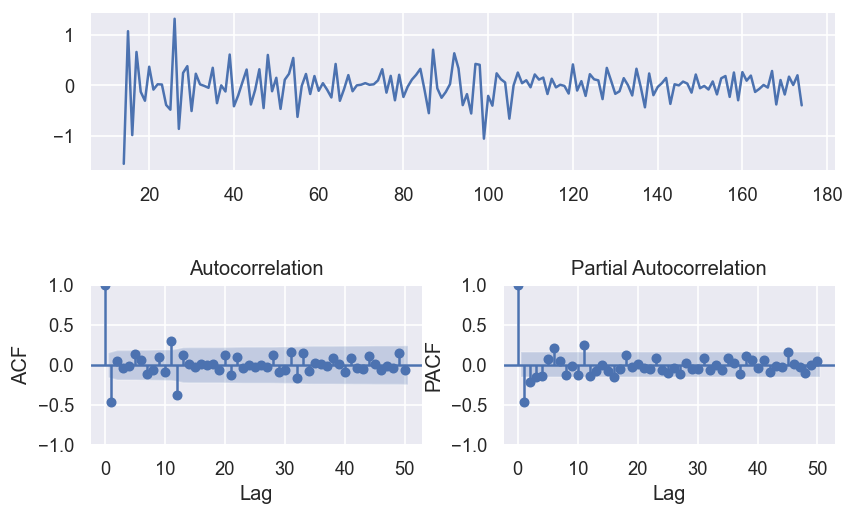

In [96]:
# Difference of the time series
d = 2
D = 1
S = 12 # Seasonality of 12 months

Bz = z
for diff in range(d):
    Bz = Bz.diff().dropna() # drop first NA value
for seas_diff in range(D):
    Bz = Bz.diff(S).dropna() # drop first NA values
FT.ts_display(Bz,lags=50)

Se podría plantear usar solo una diferenciación y aplicar modelos ARMA (se ha comprobado que esto último da ligeramente mejores resultados en entrenamiento, pero peores en test en la predicción y principales métricas).

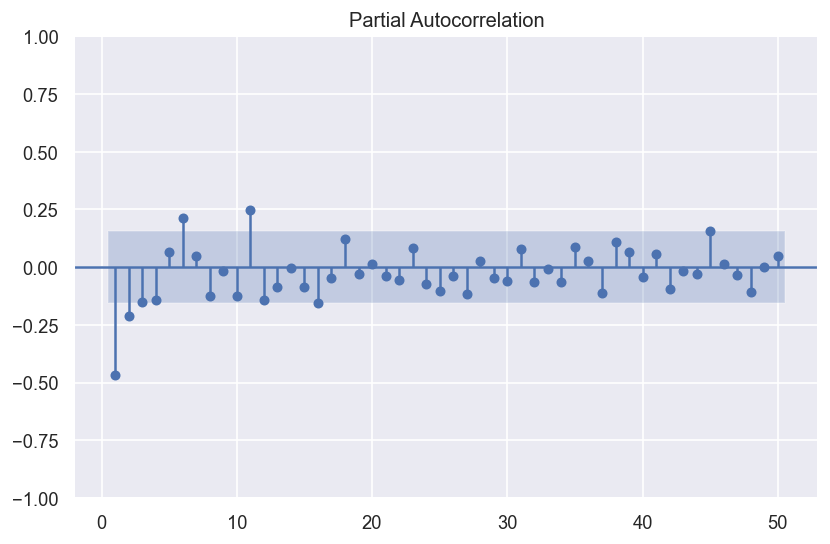

<Figure size 960x600 with 0 Axes>

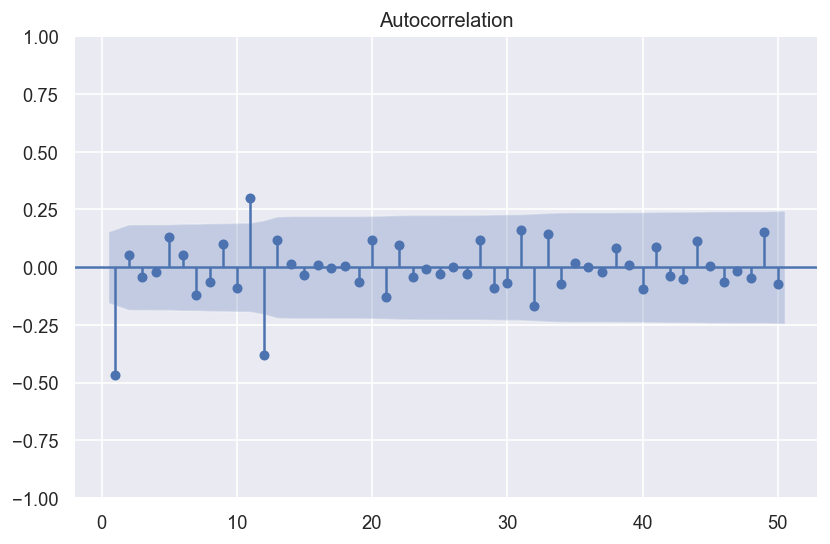

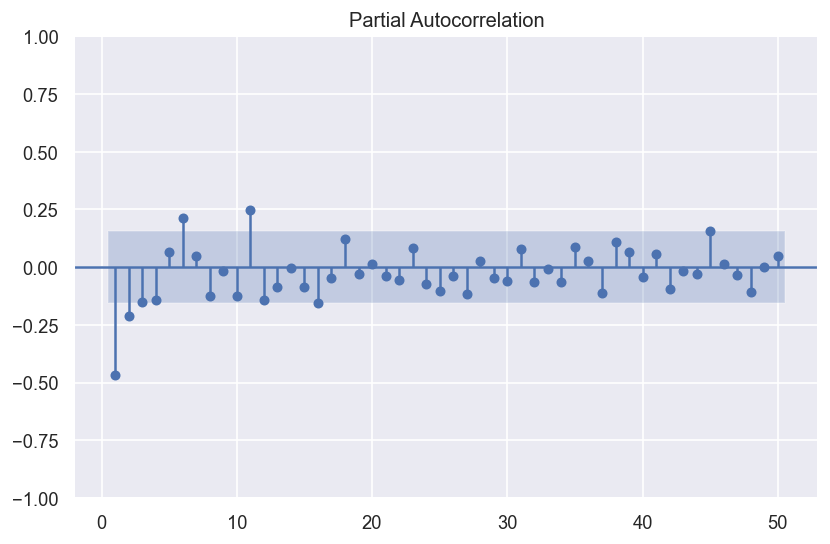

In [97]:
#Bigger plots
plt.figure()
plot_acf(Bz, lags=50,zero=False)
plot_pacf(Bz, lags=50,zero=False)

It seems necessary a moving average model (0,2,1) or an ARMA (1,1,1) for the regular terms, and a mix in the seasonal terms, or a moving average (0,1,1).

#### 5. Fit ARIMA model and check significance of the coefficients

In [98]:
# Fit model with estimated order
sarima_fit = SARIMAX(z, 
                    order=(0,2,1), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=True, 
                    enforce_stationarity=True).fit()

print(sarima_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              TOTAL   No. Observations:                  175
Model:             SARIMAX(0, 2, 1)x(0, 1, 1, 12)   Log Likelihood                  -3.797
Date:                            Wed, 29 Nov 2023   AIC                             13.594
Time:                                    10:53:51   BIC                             22.838
Sample:                                         0   HQIC                            17.347
                                            - 175                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6389      0.049    -12.986      0.000      -0.735      -0.542
ma.S.L12      -0.6934      0.080   

#### 6. Analyze residuals

Se comienzan los residuos en 20 al ser 262 datos, puesto que si se empieza desde 100 sería casi la mitad del conjunto de datos de los que no se estudian los residuos.

Ljung-Box test of residuals:
     lb_stat  lb_pvalue
25  31.81118   0.163548


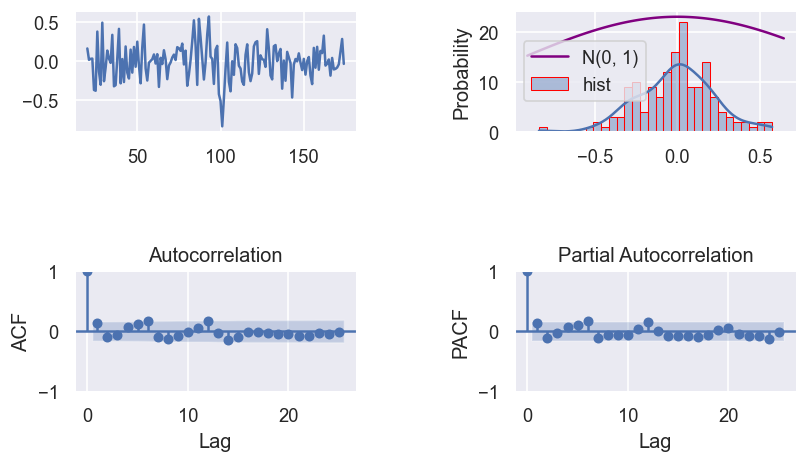

In [99]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit.resid.loc[20:]))

Este modelo es válido, siendo el mejor en términos de AIC, BIC, relación entre el número de coeficientes y precisión, etc. No obstante, se puede crear otro modelo incluyendo variables no significativas a costa de unos mejores resultados de residuos, debido a que el sexto residuo parece algo significativo en el anterior gráfico (Puede ser debido a que no se capte de forma perfecta el efecto estacional).

In [100]:
# Fit model with estimated order
sarima_fit2 = SARIMAX(z, 
                    order=(6,2,0), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=True, 
                    enforce_stationarity=True).fit()

print(sarima_fit2.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                TOTAL   No. Observations:                  175
Model:             SARIMAX(6, 2, 0)x(0, 1, [1], 12)   Log Likelihood                   0.725
Date:                              Wed, 29 Nov 2023   AIC                             14.550
Time:                                      10:53:52   BIC                             39.201
Sample:                                           0   HQIC                            24.559
                                              - 175                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6498      0.061    -10.597      0.000      -0.770      -0.530
ar.L2         -0.40

#### 6. Analyze residuals

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  18.328867   0.828116


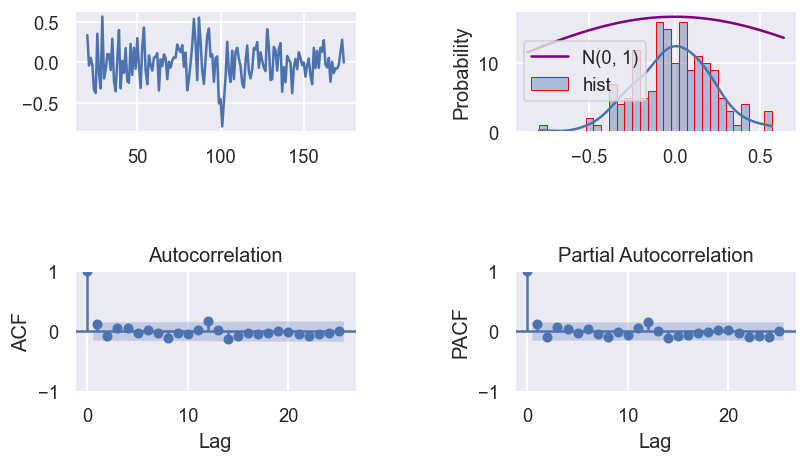

In [101]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit2.resid.loc[20:]))

Es mejor en términos de error, pero a grandes rasgos parece más correcto el primero. Observamos a continuación su desempeño en test.

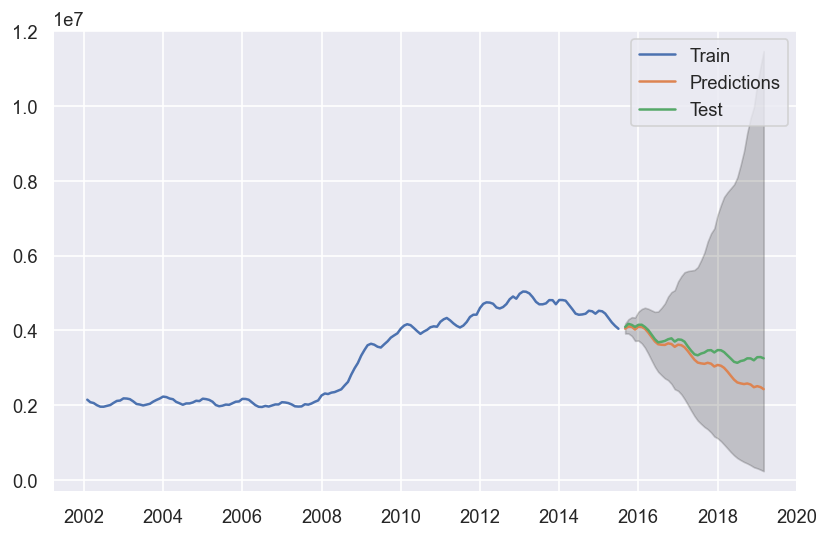

In [102]:
#Obtain forecasts for in-sample and out-of-sample
start = round(0.64*y.shape[0])
end = round(0.8*y.shape[0])
horizon = end - round(0.64*y.shape[0])

pred = sarima_fit.get_prediction(start=start+1, end= end-1, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end]

# Asegurarse de que los índices de yhat_conf_int coincidan con y_train
yhat_conf_int.index = y.index[start+1:end]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train['2002-02-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test, label = 'Test')
plt.legend()
plt.show()

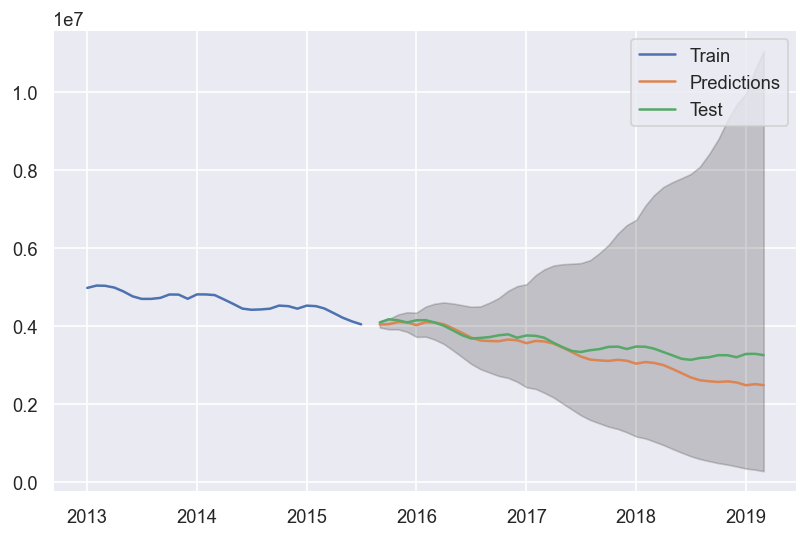

In [103]:
#Obtain forecasts for in-sample and out-of-sample
start = round(0.64*y.shape[0]) + 1
end = round(0.8*y.shape[0])
horizon = end - start

pred = sarima_fit.get_forecast(steps=horizon, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start:end]

# Asegurarse de que los índices de yhat_conf_int coincidan con y_train
yhat_conf_int.index = y.index[start:end]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train['2013-01-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test, label = 'Test')
plt.legend()
plt.show()

Resultados de BIC y AIC para los modelos en test:

In [104]:
pred = sarima_fit.get_forecast(steps=horizon, dynamic=False)
yhat = pred.predicted_mean
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

#Test MAE - Mean Absolute error
print('Test MAE SARIMA 1 d = 2:',mean_absolute_error(y_test, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA 1 d = 2:',math.sqrt(mean_squared_error(y_test, yhat)))

Test MAE SARIMA 1 d = 2: 266762.51572905364
Test RMSE SARIMA 1 d = 2: 361027.32566021616


In [105]:
# Fit model with estimated order
sarima_fit_aux = SARIMAX(z, 
                    order=(1,1,1), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=True, 
                    enforce_stationarity=True).fit()

pred = sarima_fit_aux.get_forecast(steps=horizon, dynamic=False)
yhat = pred.predicted_mean
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

#Test MAE - Mean Absolute error
print('Test MAE SARIMA 1 d = 1:',mean_absolute_error(y_test, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA 1 d = 1:',math.sqrt(mean_squared_error(y_test, yhat)))

Test MAE SARIMA 1 d = 1: 210418.61824193754
Test RMSE SARIMA 1 d = 1: 240303.79200295912


In [106]:
pred = sarima_fit2.get_forecast(steps=horizon, dynamic=False)
yhat = pred.predicted_mean
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

#Test MAE - Mean Absolute error
print('Test MAE SARIMA 2:',mean_absolute_error(y_test, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA 2:',math.sqrt(mean_squared_error(y_test, yhat)))

Test MAE SARIMA 2: 235021.70154090892
Test RMSE SARIMA 2: 320213.99619662866


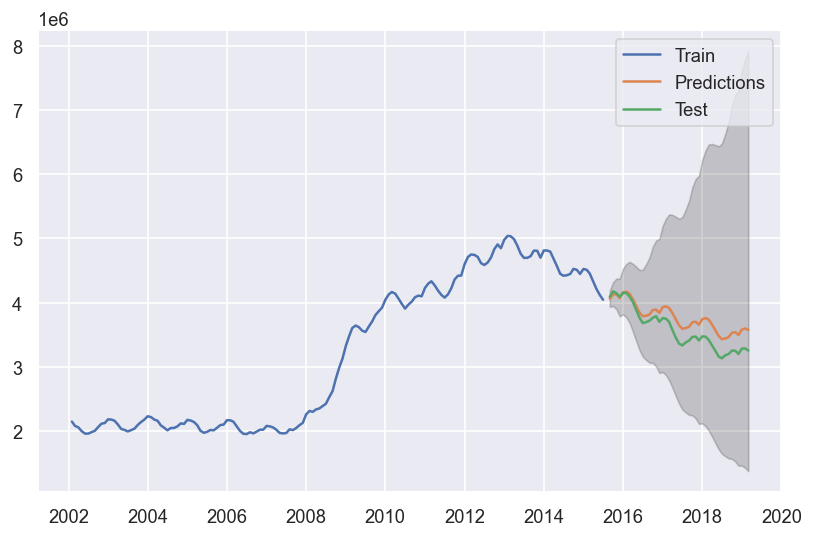

In [107]:
#Obtain forecasts for in-sample and out-of-sample
start = round(0.64*y.shape[0])
end = round(0.8*y.shape[0])
horizon = end - round(0.64*y.shape[0])

pred = sarima_fit_aux.get_prediction(start=start+1, end= end-1, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end]

# Asegurarse de que los índices de yhat_conf_int coincidan con y_train
yhat_conf_int.index = y.index[start+1:end]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train['2002-02-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test, label = 'Test')
plt.legend()
plt.show()

A pesar de lo esperado, el mejor modelo es `sarima_fit_aux` en términos de métricas y simplicidad (con unas predicciones similares), por lo que se usará este modelo a continuación en el conjunto de entrenamiento con prácticamente la totalidad de los datos para reajustar los parámetros sabiendo que es el mejor posible, aplicando los mismos pasos que anteriormente y observando los resultados finales.

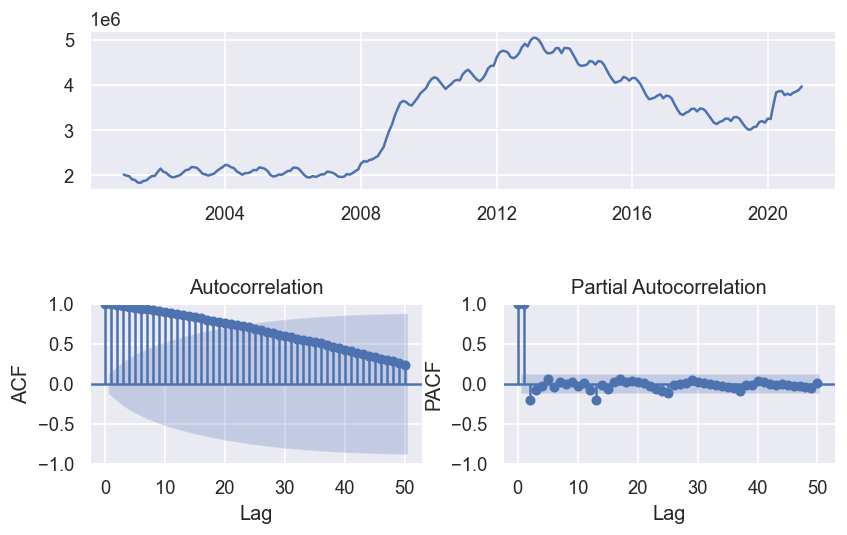

In [108]:
# ACF and PACF of the time series -> identify significant lags and order
FT.ts_display(y_train2,lags=50)

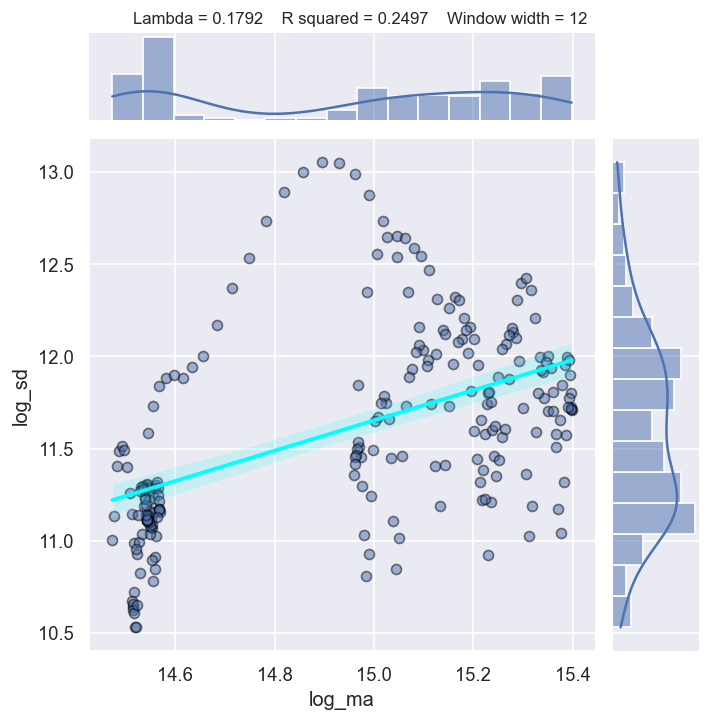

In [109]:
# Box-Cox transformation
lmbda = FT.boxcox_lambda_plot(y_train2, window_width=12)

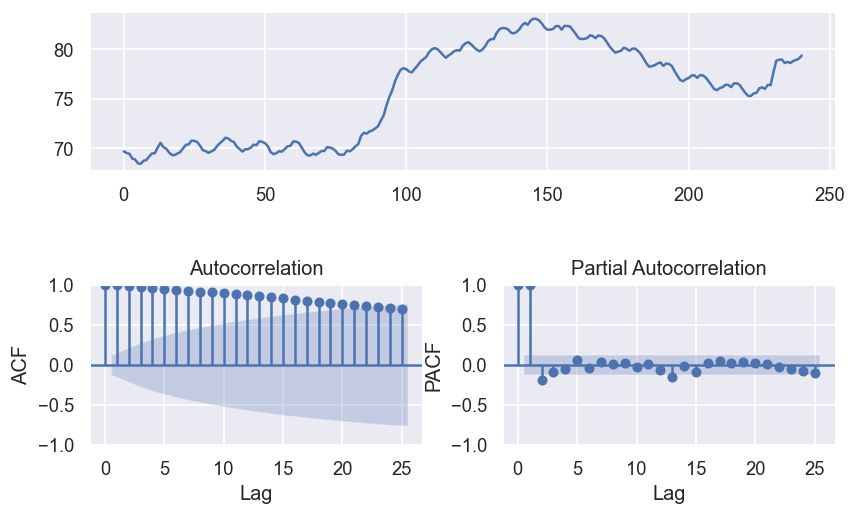

In [110]:
# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    z = st.boxcox(y_train2.values[:,0],   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df.values[:,0] - min(df.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=y_train2.columns.values.tolist())
else:
    z = y_train2

# Plot transformed data
FT.ts_display(z)

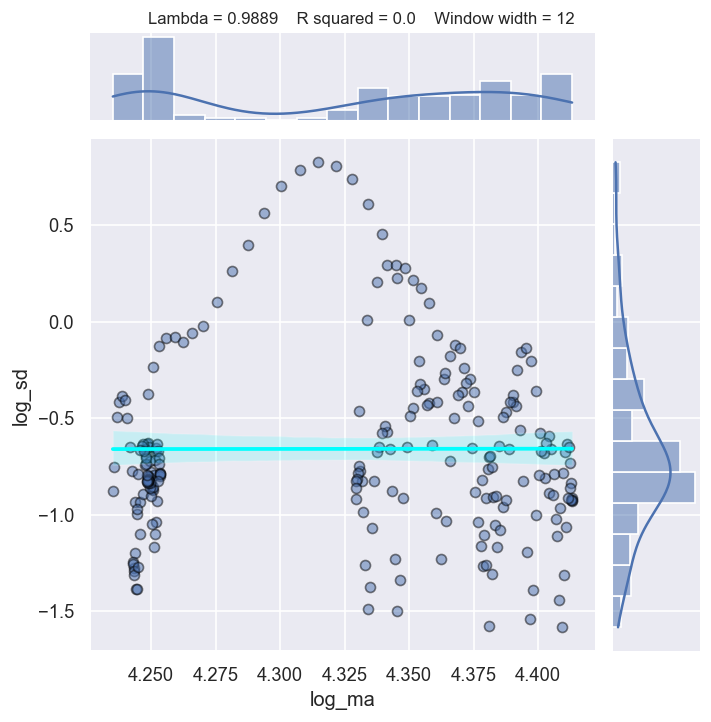

0.9889334090138303

In [111]:
#Check Box Cox of transformed series
FT.boxcox_lambda_plot(z, window_width=12)

In [112]:
# Alternative test - Augmented Dickey Fuller Test
result = adfuller(z.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.593455
p-value: 0.486880
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.574


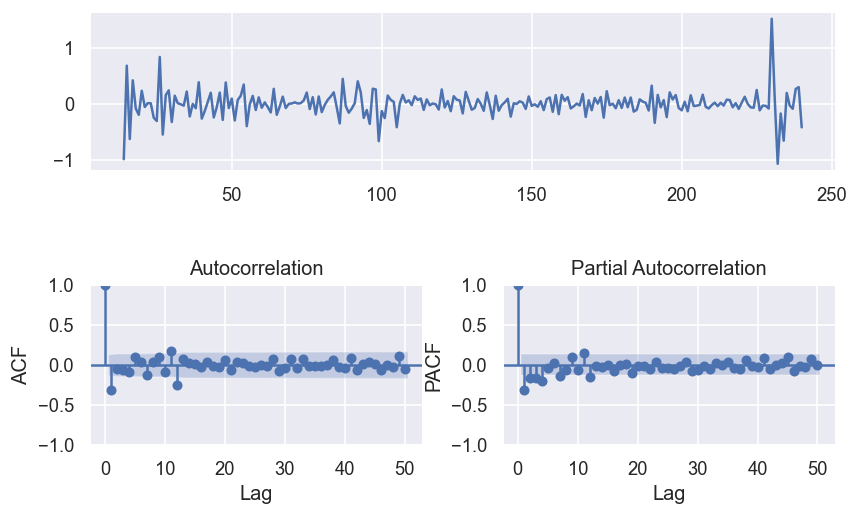

In [113]:
# Difference of the time series
d = 2
D = 1
S = 12 # Seasonality of 12 months

Bz = z
for diff in range(d):
    Bz = Bz.diff().dropna() # drop first NA value
for seas_diff in range(D):
    Bz = Bz.diff(S).dropna() # drop first NA values
FT.ts_display(Bz,lags=50)

Parece que nos lleva a resultados similares, aunque al final de la serie se observa un cambio muy grande en la serie debido a lo anteriormente comentado: el COVID.

In [114]:
# Fit model with estimated order
sarima_fit = SARIMAX(z, 
                    order=(1,2,1), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=True, 
                    enforce_stationarity=True).fit()

print(sarima_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              TOTAL   No. Observations:                  241
Model:             SARIMAX(1, 2, 1)x(0, 1, 1, 12)   Log Likelihood                  54.759
Date:                            Wed, 29 Nov 2023   AIC                           -101.518
Time:                                    10:54:03   BIC                            -87.819
Sample:                                         0   HQIC                           -95.990
                                            - 241                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4413      0.053      8.331      0.000       0.337       0.545
ma.L1         -0.8857      0.038   

Observamos que en este caso admite también un término autorregresivo, siendo éste un pequeño reajuste como los que hablábamos.

Ljung-Box test of residuals:
     lb_stat  lb_pvalue
25  9.948478   0.996789


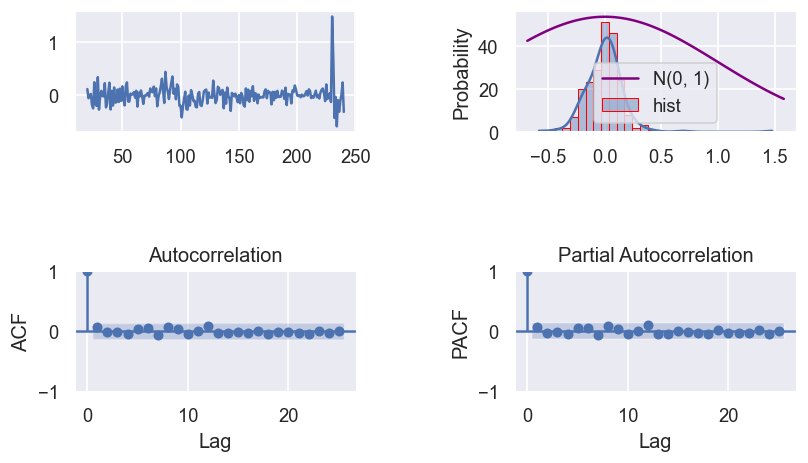

In [115]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit.resid.loc[20:]))

El error es bastante bueno, se observan a continuación diversas métricas y la predicción.

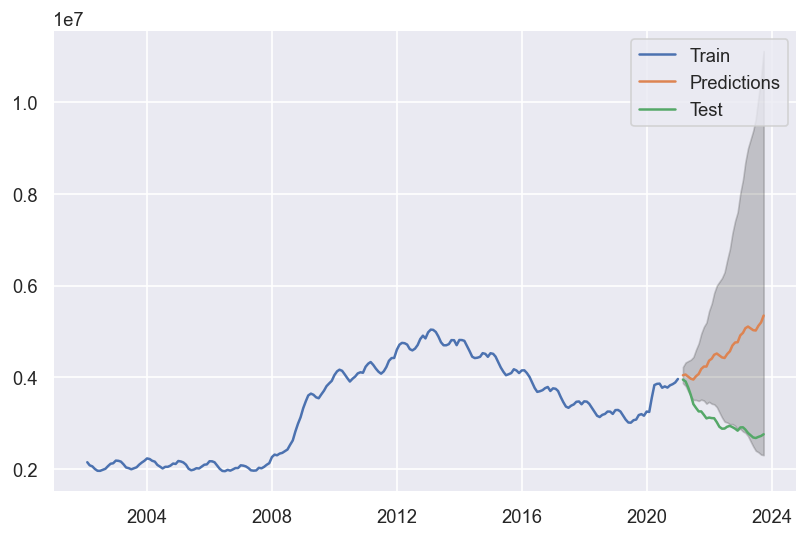

In [116]:
#Obtain forecasts for in-sample and out-of-sample
start = round(prop_train*y.shape[0])
end = round(y.shape[0])
horizon = end - round(prop_train*y.shape[0])

pred = sarima_fit.get_prediction(start=start+1, end= end-1, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end]

# Asegurarse de que los índices de yhat_conf_int coincidan con y_train
yhat_conf_int.index = y.index[start+1:end]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train2['2002-02-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test2, label = 'Test')
plt.legend()
plt.show()

Como se puede observar, la predicción es bastante mala, no captando en absoluto la bajada. Por tanto, se pueden probar otros modelos como el inicial (0,2,1) o el otro posible comentado al comienzo con una diferenciación (1,1,1). El primero mejora algo los errores, pero sigue sin captar la tendencia. El segundo, sin embargo, además de ser más sencillo, sus resultados son mejores, pero tiene una explicación.

In [117]:
#Test MAE - Mean Absolute error
print('Test MAE SARIMA 1 d = 2:',mean_absolute_error(y_test2, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA 1 d = 2:',math.sqrt(mean_squared_error(y_test2, yhat)))

Test MAE SARIMA 1 d = 2: 1497738.4608779866
Test RMSE SARIMA 1 d = 2: 1663834.0054780615


In [118]:
# Fit model with estimated order
sarima_fit2 = SARIMAX(z, 
                    order=(1,1,1), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=True, 
                    enforce_stationarity=True).fit()

print(sarima_fit2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              TOTAL   No. Observations:                  241
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                  56.307
Date:                            Wed, 29 Nov 2023   AIC                           -104.615
Time:                                    10:54:05   BIC                            -90.898
Sample:                                         0   HQIC                           -99.080
                                            - 241                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7409      0.055     13.457      0.000       0.633       0.849
ma.L1         -0.2090      0.068   

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  15.473913   0.929598


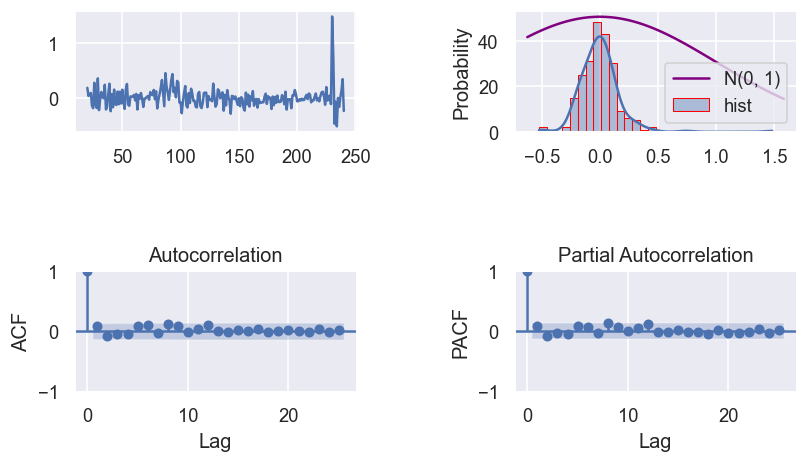

In [119]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit2.resid.loc[20:]))

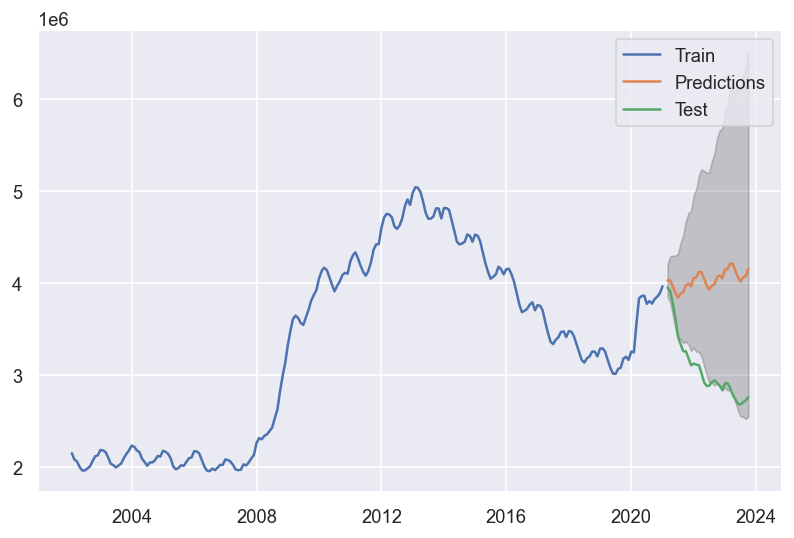

In [120]:
#Obtain forecasts for in-sample and out-of-sample
start = round(prop_train*y.shape[0])
end = round(y.shape[0])
horizon = end - round(prop_train*y.shape[0])

pred = sarima_fit2.get_prediction(start=start+1, end= end-1, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end]

# Asegurarse de que los índices de yhat_conf_int coincidan con y_train
yhat_conf_int.index = y.index[start+1:end]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train2['2002-02-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test2, label = 'Test')
plt.legend()
plt.show()

In [121]:
#Test MAE - Mean Absolute error
print('Test MAE SARIMA 1 d = 1:',mean_absolute_error(y_test2, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA 1 d = 1:',math.sqrt(mean_squared_error(y_test2, yhat)))

Test MAE SARIMA 1 d = 1: 969387.062384741
Test RMSE SARIMA 1 d = 1: 1046712.2232051054


Como se puede observar, este modelo menos complejo simplemente sigue con mayor exactitud los últimos datos reales, por lo que su menor error es pura coincidencia, fruto de la bajada repentina, pero no quiere decir que en general sea un mejor modelo o sobreajuste menos que los anteriores (aún así, su intervalo de confianza es menor, lo cual es bueno). De hecho, parecen modelos más precisos los previos, pero claramente ninguno es capaz de capturar esa gran bajada, como es lógico.

No obstante, los residuos son claramente independientes en todos los casos, y no se observa ningún retardo significativo. No obstante, se puede ver un gran outlier que, junto con lo comentado anteriormente, nos indica de la gran necesidad de añadir algún tipo de tendencia o parámetro para modelar los efectos del COVID como, por ejemplo, una variable de intervención. Por tanto, ése será el siguiente paso.

# **SARIMAX**

Se procede a incluir una variable de intervención que palie el efecto provocado por el COVID en nuestra serie temporal.

Esta variable simplemente será una binaria que tome el valor 1 para observaciones en fechas dentro del periodo en que el COVID tuvo un efecto en la serie, y 0 para las fechas fuera de dicho periodo.

In [413]:
df['COVID']=0

# Definir el período de COVID-19 (por ejemplo, desde marzo de 2020 hasta la fecha final)
periodo_covid_inicio = pd.to_datetime('2020-03-01')
periodo_covid_fin_1 = pd.to_datetime('2021-07-01') #Parece que aquí termina su influencia en nuestra serie
# Establecer los valores de la columna 'Periodo_Covid' a 1 durante el periodo de COVID-19
df.loc[periodo_covid_inicio:periodo_covid_fin_1, 'COVID'] = 1


df['COVID'].describe()#únicamente el COVID afecta a un 11% de nuestras observaciones

count    274.000000
mean       0.000000
std        0.352905
min       -1.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: COVID, dtype: float64

In [414]:
INPUTS_SARMAX = ['COVID']
OUTPUT = 'TOTAL'

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = df[INPUTS_SARMAX]
y = df[OUTPUT]

## Divide the data into training and test sets SEQUENTIALY -------------------------------------
# Create random 80/20 % split
X_train2 = X.iloc[0:round(prop_train*X.shape[0])]
X_test2 = X.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]
y_train2 = y.iloc[0:round(prop_train*X.shape[0])]#Esto creo que está hecho arriba, luego lo cambio
y_test2 = y.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]



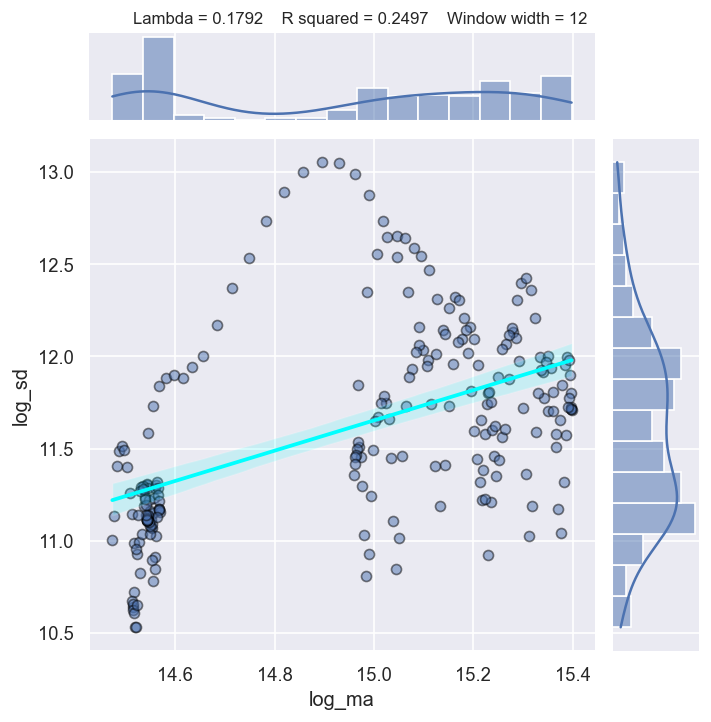

In [415]:
lmbda = FT.boxcox_lambda_plot(y_train2, window_width=12)

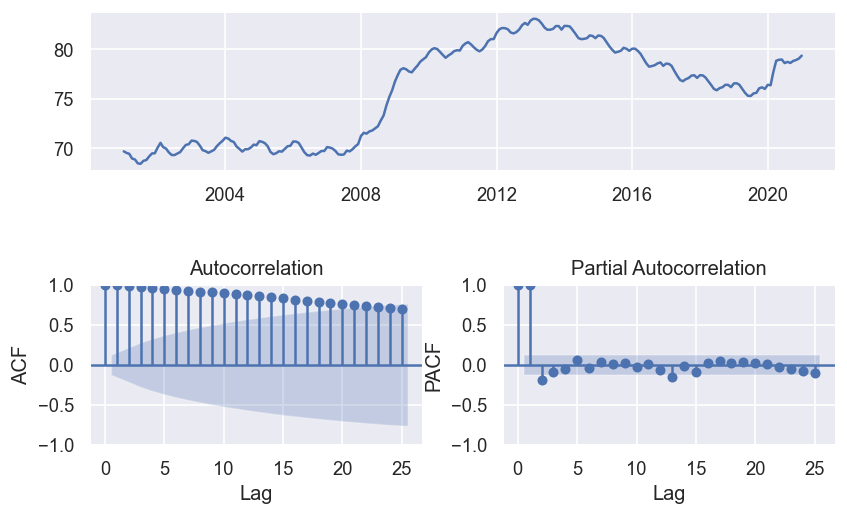

In [416]:
#!!!!!Revisar si hace falta o con lo hecho por Juan vale
# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    z = st.boxcox(y_train2.values,   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df.values[:,0] - min(df.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=y_train.columns.values.tolist())
else:
    z = y_train2

# Plot transformed data
z.index=y_train2.index
FT.ts_display(z)

In [420]:
#time_varying_regression
# We could also fit a more complicated model with ARMA with seasonal components.
mod_sarimax = sm.tsa.SARIMAX(endog = z, 
                            order=(1,1,1),
                            seasonal_order=(0,1,1,12),
                            exog = X_train2[INPUTS_SARMAX],
                            trend='n',
                            enforce_invertibility=True, 
                            enforce_stationarity=True,
                            time_varying_regression=False,
                            mle_regression=True)
res_sarimax = mod_sarimax.fit()

# Show the summary of results
print(res_sarimax.summary())

c:\Users\juanl\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\juanl\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                               TOTAL   No. Observations:                  241
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood                  50.704
Date:                             Wed, 29 Nov 2023   AIC                            -93.409
Time:                                     12:12:18   BIC                            -79.691
Sample:                                 01-01-2001   HQIC                           -87.874
                                      - 01-01-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
COVID          1.0279      0.074     13.914      0.000       0.883       1.173
ar.L1          0.8163      

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
50  50.434931   0.456185


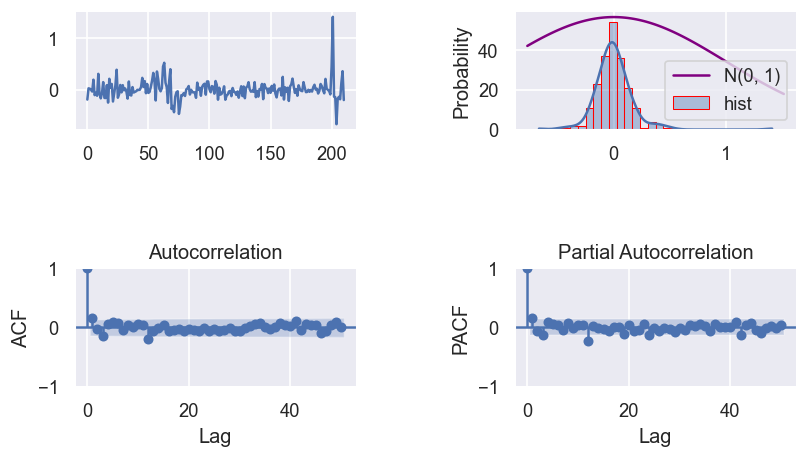

In [421]:
# Plot residual error
plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})
FT.check_residuals(pd.DataFrame(res_sarimax.resid.values[30:]),lags=50)
 

Se ha iniciando probando el modelo óptimo obtenido en el SARIMA(1,2,1)x(0,1,1,12) obteniendo resultados muy malos para los residuos, tras ello se han seguido probando modelos incluyendo diferenciación tanto regular como estacional en los modelos, siempre observando correlaciones parciales muy altas entre los residuos de la serie y sus retardos estacionales(E(12),E(24),E(36,...)).Cambiar los parámetros del sarimax en el código para ver este fenómeno.

Por último, se decidió eliminar la diferenciación estacional para ver si de esta manera se conseguía eliminar este efecto, y se consiguió, llegando al modelo óptimo mostrado arriba, en que prácticamenete con un 100% de confianza se afirma que los residuos del modelo son ruido blanco(Ver p-valor del test de Ljung-Box).

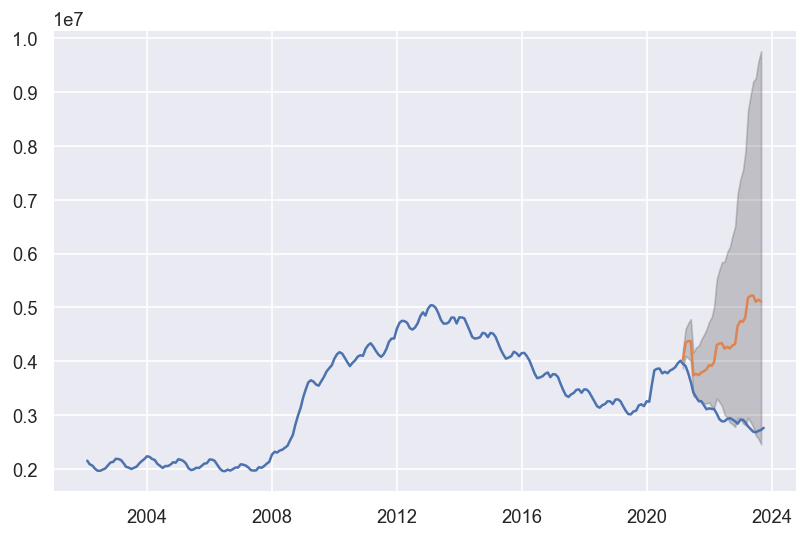

In [422]:
#Obtain forecasts for in-sample and out-of-sample
start = round(prop_train*y.shape[0])
end = round(y.shape[0])
horizon = end - start

pred = res_sarimax.get_prediction(start=start+1, 
                                    end= end-2, 
                                    exog = X_test2[INPUTS_SARMAX],
                                    dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end-1]


plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y['2002-02-01':])
plt.plot(yhat['2002-02-01':])
plt.show()

In [400]:
 #Test MAE - Mean Absolute error
y_test2=y_test2[:'2023-09-01']
print('Test MAE SARIMA 1 d = 2:',mean_absolute_error(y_test2, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA 1 d = 2:',math.sqrt(mean_squared_error(y_test2, yhat)))

Test MAE SARIMA 1 d = 2: 674663.5721947587
Test RMSE SARIMA 1 d = 2: 735111.6145124132


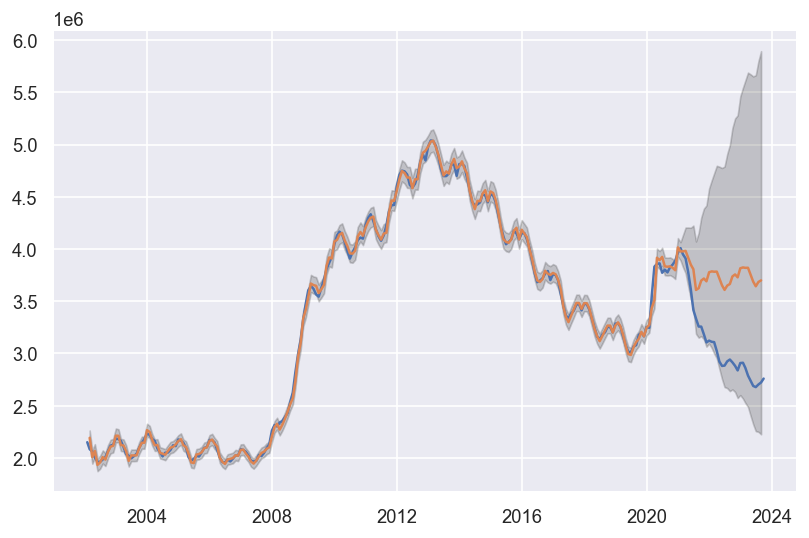

In [402]:
#Obtain forecasts for in-sample and out-of-sample
start = 13
end = round(y.shape[0])

pred = res_sarimax.get_prediction(start=start+1, 
                                    end= end-2, 
                                    exog = X_test2[INPUTS_SARMAX],
                                    dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end-1]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y['2002-02-01':])
plt.plot(yhat['2002-02-01':])
plt.show()

# MLP

In [195]:
###Include lagged variables
dfT = df[['TOTAL']].copy()
dfT['TOTAL_lag1'] = dfT['TOTAL'].shift()
dfT['TOTAL_lag2'] = dfT['TOTAL'].shift(2)
dfT['TOTAL_lag3'] = dfT['TOTAL'].shift(3)
dfT['TOTAL_lag4'] = dfT['TOTAL'].shift(12)
dfT['TOTAL_lag5'] = dfT['TOTAL'].shift(13)

dfT.head()

,TOTAL,TOTAL_lag1,TOTAL_lag2,TOTAL_lag3,TOTAL_lag4,TOTAL_lag5
DATE,,,,,,
2001-01-01,2017389,NaN,NaN,NaN,NaN,NaN
2001-02-01,1993273,2017389.0,NaN,NaN,NaN,NaN
2001-03-01,1981006,1993273.0,2017389.0,NaN,NaN,NaN
2001-04-01,1910453,1981006.0,1993273.0,2017389.0,NaN,NaN
2001-05-01,1898285,1910453.0,1981006.0,1993273.0,NaN,NaN


In [199]:
# Remove missing
dfT.dropna(inplace=True)
dfT.head()

,TOTAL,TOTAL_lag1,TOTAL_lag2,TOTAL_lag3,TOTAL_lag4,TOTAL_lag5
DATE,,,,,,
2002-02-01,2149907,2075022.0,1988716.0,1985857.0,1993273.0,2017389.0
2002-03-01,2083103,2149907.0,2075022.0,1988716.0,1981006.0,1993273.0
2002-04-01,2060069,2083103.0,2149907.0,2075022.0,1910453.0,1981006.0
2002-05-01,2002923,2060069.0,2083103.0,2149907.0,1898285.0,1910453.0
2002-06-01,1962963,2002923.0,2060069.0,2083103.0,1842556.0,1898285.0


In [211]:
# Define input and output matrices
INPUTS = ['TOTAL_lag1','TOTAL_lag2','TOTAL_lag3','TOTAL_lag4','TOTAL_lag5']
OUTPUT = 'TOTAL'

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = dfT[INPUTS]
y = dfT[OUTPUT]

## Divide the data into training and test sets SEQUENTIALY -------------------------------------
# Create random 80/20 % split
X_train = X.iloc[0:round(0.64*y.shape[0])]
X_test = X.iloc[round(0.64*y.shape[0])+1:round(0.8*y.shape[0])]
y_train = y.iloc[0:round(0.64*y.shape[0])]
y_test = y.iloc[round(0.64*y.shape[0])+1:round(0.8*y.shape[0])]

## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['TOTAL'] = y_train # We will call Y as output variable for simplicity
dfTS_eval = X_test.copy()
dfTS_eval['TOTAL'] = y_test # We will call Y as output variable for simplicity

X_train.head()

,TOTAL_lag1,TOTAL_lag2,TOTAL_lag3,TOTAL_lag4,TOTAL_lag5
DATE,,,,,
2002-02-01,2075022.0,1988716.0,1985857.0,1993273.0,2017389.0
2002-03-01,2149907.0,2075022.0,1988716.0,1981006.0,1993273.0
2002-04-01,2083103.0,2149907.0,2075022.0,1910453.0,1981006.0
2002-05-01,2060069.0,2083103.0,2149907.0,1898285.0,1910453.0
2002-06-01,2002923.0,2060069.0,2083103.0,1842556.0,1898285.0


In [229]:
#------------------------------- MLP Regression MODEL -------------------------------------------------
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_MLP_NUM = ['TOTAL_lag1','TOTAL_lag2','TOTAL_lag3','TOTAL_lag4','TOTAL_lag5']
INPUTS_MLP_CAT = [] #Weekday is numerical in this case - Intervention variables
INPUTS_MLP = INPUTS_MLP_NUM + INPUTS_MLP_CAT

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_MLP_NUM)
        ])

param = {'MLP__alpha': [0.01,0.1,1,10], # Initial value of regularization
         'MLP__hidden_layer_sizes':[(3,),(5,),(5,5),(5,10),(10,)]} # Number of neurons in each hidden layer, enters as tuples

pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('MLP', MLPRegressor(solver='lbfgs', # Update function
                activation='logistic', # Logistic sigmoid activation function
                max_iter=450, # Maximum number of iterations
                tol=1e-4, # Tolerance for the optimization
                random_state=150,
                verbose = True))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
MLP_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='neg_mean_squared_error', # RMSE https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
MLP_fit.fit(X_train[INPUTS_MLP], y_train) # Search in grid
print("MLP Trained")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.33606D+12    |proj g|=  3.37417D+06

At iterate    1    f=  6.33570D+12    |proj g|=  1.86043D+07

At iterate    2    f=  1.19159D+12    |proj g|=  3.86890D+09

At iterate    3    f=  7.53684D+11    |proj g|=  6.91762D+05
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.32889D+12    |proj g|=  3.37073D+06
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.33186D+12    |proj g|=  3.37213D+06

At iterate    1    f=  6.32853D+12    |proj g|=  1.85486D+07

At iterate    1    f=  6.33149D+12    |proj g|=  1.85634D+07

At

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point af

 iterate    2    f=  1.15468D+12    |proj g|=  1.07694D+06

At iterate    4    f=  7.22986D+11    |proj g|=  5.82561D+05

At iterate    5    f=  6.56950D+11    |proj g|=  1.39267D+07

At iterate    6    f=  2.42440D+11    |proj g|=  5.87563D+05

At iterate    7    f=  9.39502D+10    |proj g|=  1.97201D+05

At iterate    3    f=  1.15002D+12    |proj g|=  3.89772D+06

At iterate    2    f=  1.14998D+12    |proj g|=  1.07179D+06

At iterate    4    f=  7.39246D+11    |proj g|=  6.54992D+05

At iterate    8    f=  9.36679D+10    |proj g|=  3.80494D+05

At iterate    9    f=  8.54605D+10    |proj g|=  1.44130D+05
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.35130D+12    |proj g|=  3.38154D+06

At iterate    5    f=  7.20692D+11    |proj g|=  6.14900D+05

At iterate   10    f=  7.87667D+10    |proj g|=  1.16425D+05

At iterate    1    f=  6.3509

 evaluation;
                  2 rounding error dominate computation.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
 

+10    |proj g|=  7.38981D+05

At iterate   48    f=  5.53756D+10    |proj g|=  6.31579D+05

At iterate   49    f=  5.53756D+10    |proj g|=  1.77983D+06

At iterate   50    f=  5.53755D+10    |proj g|=  4.12920D+06

At iterate   51    f=  5.53754D+10    |proj g|=  7.43806D+06

At iterate   52    f=  5.53751D+10    |proj g|=  1.11240D+07

At iterate   53    f=  5.53746D+10    |proj g|=  1.27900D+07

At iterate   54    f=  5.53742D+10    |proj g|=  3.15823D+06

At iterate   29    f=  4.92240D+10    |proj g|=  3.41641D+08

At iterate   30    f=  4.88426D+10    |proj g|=  1.25353D+08

At iterate   31    f=  4.87230D+10    |proj g|=  6.54318D+07

At iterate   32    f=  4.86530D+10    |proj g|=  3.89734D+07

At iterate   33    f=  4.86184D+10    |proj g|=  5.27281D+07

At iterate   55    f=  5.53740D+10    |proj g|=  7.55347D+06

At iterate   34    f=  4.85951D+10    |proj g|=  3.67051D+07

At iterate   56    f=  5.53738D+10    |proj g|=  6.87319D+05

At iterate   35    f=  4.85754D+10    |

 This problem is unconstrained.


.89488D+10    |proj g|=  2.98767D+08

At iterate   90    f=  3.87320D+10    |proj g|=  1.74399D+08

At iterate   91    f=  3.86683D+10    |proj g|=  1.29852D+08

At iterate   29    f=  3.56540D+10    |proj g|=  3.65271D+08
  ys=-9.829E+09  -gs= 9.196E+02 BFGS update SKIPPED

At iterate   92    f=  3.76503D+10    |proj g|=  1.78058D+08

At iterate   93    f=  3.75698D+10    |proj g|=  5.73007D+07

At iterate   94    f=  3.75690D+10    |proj g|=  6.80904D+07

At iterate   95    f=  3.74412D+10    |proj g|=  9.81255D+07

At iterate   96    f=  3.74376D+10    |proj g|=  3.54351D+07

At iterate   97    f=  3.74305D+10    |proj g|=  1.71043D+07

At iterate   30    f=  3.56209D+10    |proj g|=  2.05528D+07

At iterate   98    f=  3.68230D+10    |proj g|=  2.29211D+07

At iterate   31    f=  3.55837D+10    |proj g|=  3.55108D+06

At iterate   32    f=  3.55809D+10    |proj g|=  5.49751D+05

At iterate   99    f=  3.68218D+10    |proj g|=  4.89992D+07

At iterate   33    f=  3.55809D+10    |pro

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


iterate   25    f=  2.04960D+10    |proj g|=  6.71772D+07


At iterate    2    f=  4.50612D+12    |proj g|=  2.75357D+06
At iterate   19    f=  5.18683D+10    |proj g|=  1.42114D+02

At iterate   26    f=  2.04574D+10    |proj g|=  4.41557D+07

At iterate   20    f=  5.18683D+10    |proj g|=  2.13014D+02

At iterate    3    f=  1.38606D+12    |proj g|=  1.04491D+06

At iterate    4    f=  2.85665D+11    |proj g|=  3.73244D+05

At iterate   27    f=  2.04434D+10    |proj g|=  9.49995D+06

At iterate   28    f=  2.04406D+10    |proj g|=  7.21273D+06

At iterate    5    f=  9.43707D+10    |proj g|=  1.74248D+05

At iterate   29    f=  2.04380D+10    |proj g|=  2.59810D+06

At iterate    7    f=  6.45781D+10    |proj g|=  1.66037D+07

At iterate   30    f=  2.04375D+10    |proj g|=  7.11550D+05

At iterate   31    f=  2.04374D+10    |proj g|=  1.63058D+05

At iterate   32    f=  2.04374D+10    |proj g|=  1.11396D+05

At iterate   33    f=  2.04374D+10    |proj g|=  5.85730D+04

At iterate 

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


ine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.55675D+12    |proj g|=  3.12990D+06

At iterate   92    f=  1.13919D+10    |proj g|=  1.55599D+07

At iterate   17    f=  4.17225D+10    |proj g|=  4.81049D+01

At iterate   18    f=  4.17225D+10    |proj g|=  5.82182D+01

At iterate   93    f=  1.13919D+10    |proj g|=  1.93167D+07

At iterate   94    f=  1.13919D+10    |proj g|=  1.31926D+07


At iterate   19    f=  4.17224D+10    |proj g|=  1.56996D+02
At iterate    9    f=  6.48042D+10    |proj g|=  9.25047D+05

At iterate   95    f=  1.13918D+10    |proj g|=  9.08812D+06

At iterate   96    f=  1.13918D+10    |proj g|=  1.82020D+07

At iterate    1    f=  5.55642D+12    |proj g|=  1.67471D+07

At iterate   97    f=  1.13918D+10    |proj g|=  1.77298D+07

At iterate   98    f=  1.13917D+10    |proj g|=  1.43531D+07

At iterate   99    f=  1.13917D+10    |proj g|=  8.74366D+06

At iterate  1

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   36     46     91      1     1     0   2.228D+05   3.435D+10
  F =   34345156452.982174     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate  318    f=  9.57994D+09    |proj g|=  6.58692D+07

At iterate  319    f=  9.57987D+09    |proj g|=  2.09275D+07

At iterate  320    f=  9.57985D+09    |proj g|=  1.64174D+07

At iterate  321    f=  9.57985D+09    |proj g|=  1.83139D+07

At iterate  322    f=  9.57981D+09    |proj g|=  3.30896D+07

At iterate  323    f=  9.57974D+09    |proj g|=  5.31357D+07

At iterate  324    f=  9.57973D+09    |proj g|=  6


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


037D+09

At iterate   77    f=  2.17634D+10    |proj g|=  7.81805D+04

At iterate   27    f=  8.61253D+09    |proj g|=  1.80168D+09

At iterate   78    f=  2.17634D+10    |proj g|=  1.39889D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   36     78    212      1     1     0   1.399D+04   2.176D+10
  F =   21763359546.296516     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   28    f=  8.07448D+09    |proj g|=  4.87519D+08

At iterate   29    f=  7.95689D+09    |proj g|=  4.45725D+08

At iterate   30    f=  7.71805D+09    |proj g|=  1.04789D+09

At iterate   31    f=  7.56127D+09    |pro


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (stat

        F
   66     19     81      2     0     0   1.778D+01   6.480D+11
  F =   647992294353.27173     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   24    f=  1.19586D+10    |proj g|=  4.46586D+08

At iterate   25    f=  1.18504D+10    |proj g|=  8.91751D+08

At iterate   26    f=  1.17612D+10    |proj g|=  2.16655D+08

At iterate   27    f=  1.17219D+10    |proj g|=  4.36898D+08

At iterate   28    f=  1.17201D+10    |proj g|=  1.50833D+08

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
At iterate   29    f=  1.17182D+10    |proj g|=  4.88418D+07
 N =           66     M =           10
RUNNING THE L-BFGS-B CODE


At X0         0 variables are exactly at the bounds
           * * *

Machine precision = 2.220D-16
 N =           66     M =           10

At X0         0 variables are exactly at the bounds
RUNNING THE L-BFGS-B CODE

At iterate    0    f=  6.35131D+12    |proj g|=  3.38154D+06

At iterate    0    f=  6.19724D+12    


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.


72D+11    |proj g|=  3.44157D+01

At iterate    5    f=  6.01063D+11    |proj g|=  2.95675D+01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          101     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.33606D+12    |proj g|=  3.37417D+06
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16

 N =           66     M =           10
At iterate    1    f=  6.33594D+12    |proj g|=  5.03901D+06

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.73911D+12    |proj g|=  3.17314D+06
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           66     M =           10


At X0         0 variables are exactly at the bounds
At iterate    1    f=  5.73903D+12    |proj g|=  5.38982D+06

At iterate    0    f=  5.31745D+12    |proj g|=  3.07712D+06

At iterate    6    f=  6.01063D+11    |proj g|=  2.31049D+01


At iterate    2    f=  5.00775

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


 = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   66     18    159      3     0     0   9.387D+04   9.753D+10
  F =   97526346941.302185     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   25    f=  3.00361D+11    |proj g|=  1.38433D+06

At iterate    9    f=  4.14345D+11    |proj g|=  9.05965D+05

At iterate   10    f=  3.73572D+11    |proj g|=  1.40515D+06

At iterate   11    f=  3.70247D+11    |proj g|=  1.05114D+06

At iterate    7    f=  4.51285D+11    |proj g|=  5.64081D+05

At iterate   12    f=  3.70128D+11    |proj g|=  1.57462D+07

At iterate   13    f=  3.69962D+11    |proj g|=  2.43862D+07
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          101 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


iterate   10    f=  3.61610D+11    |proj g|=  4.44807D+05

At iterate    5    f=  6.01100D+11    |proj g|=  9.40666D+01

At iterate   11    f=  3.50980D+11    |proj g|=  4.02959D+05

At iterate   16    f=  4.34518D+10    |proj g|=  3.78356D+02

At iterate    6    f=  4.07763D+11    |proj g|=  5.17843D+05

At iterate   14    f=  5.96256D+10    |proj g|=  6.91780D+03

At iterate    7    f=  4.07762D+11    |proj g|=  5.17838D+05

At iterate    8    f=  3.88747D+11    |proj g|=  4.85025D+05

At iterate   12    f=  3.50965D+11    |proj g|=  4.02947D+05

At iterate    9    f=  3.85248D+11    |proj g|=  4.89216D+05
  ys=-4.668E+06  -gs= 2.274E+09 BFGS update SKIPPED

At iterate   13    f=  3.48571D+11    |proj g|=  2.09544D+07

At iterate   14    f=  3.47730D+11    |proj g|=  3.90678D+05

At iterate   15    f=  3.37539D+11    |proj g|=  3.17732D+05

At iterate   15    f=  5.96256D+10    |proj g|=  5.77314D+03

At iterate   16    f=  5.96256D+10    |proj g|=  2.39374D+03

At iterate   17    f=


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


6D+10    |proj g|=  1.50966D+03

At iterate   65    f=  4.62569D+10    |proj g|=  1.04852D+06

At iterate   47    f=  4.72793D+10    |proj g|=  1.96306D+03

At iterate   56    f=  4.61438D+10    |proj g|=  7.62722D+05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  101     56    234      2     3     0   7.627D+05   4.614D+10
  F =   46143786116.944107     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   66    f=  4.62568D+10    |proj g|=  9.42993D+05

At iterate   67    f=  4.62568D+10    |proj g|=  1.98222D+06

At iterate   68    f=  4.62566D+10    |proj g|=  1.51398D+06

At iterate   48   

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



8D+05

At iterate   17    f=  4.17148D+10    |proj g|=  1.95532D+03

At iterate   15    f=  5.30094D+10    |proj g|=  2.15205D+05

At iterate   25    f=  4.67937D+10    |proj g|=  1.06017D+03

At iterate   16    f=  5.06475D+10    |proj g|=  4.03308D+05

At iterate    9    f=  4.42654D+11    |proj g|=  5.16498D+05

At iterate   17    f=  5.05756D+10    |proj g|=  3.78776D+05

At iterate   26    f=  4.67924D+10    |proj g|=  4.01181D+04

At iterate   27    f=  4.67920D+10    |proj g|=  1.11005D+05




At iterate   28    f=  4.67847D+10    |proj g|=  9.70799D+03
At iterate   10    f=  4.37277D+11    |proj g|=  5.15058D+05
At iterate   18    f=  4.17110D+10    |proj g|=  2.83546D+02
At iterate   18    f=  5.05652D+10    |proj g|=  1.26994D+05


At iterate   29    f=  4.67652D+10    |proj g|=  4.16397D+04
At iterate   19    f=  5.05604D+10    |proj g|=  1.40536D+05

At iterate   20    f=  5.05566D+10    |proj g|=  1.12642D+05

At iterate   19    f=  4.17109D+10    |proj g|=  1.02317D+02

A

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   31    f=  2.73386D+10    |proj g|=  1.45517D+04

At iterate   32    f=  2.72312D+10    |proj g|=  6.78640D+03

At iterate   48    f=  4.67317D+10    |proj g|=  1.60969D+02

At iterate   33    f=  2.72048D+10    |proj g|=  5.31349D+03

At iterate   34    f=  2.70398D+10    |proj g|=  7.72931D+03

At iterate   35    f=  2.67795D+10    |proj g|=  1.25055D+04

At iterate   36    f=  2.63481D+10    |proj g|=  1.42483D+04


At iterate   49    f=  4.67317D+10    |proj g|=  1.85568D+02


RUNNING THE L-BFGS-B CODE

At iterate   50    f=  4.67317D+10    |proj g|=  1.32323D+02
At iterate   37    f=  2.59418D+10    |proj g|=  2.66353D+06
           * * *

Machine precision = 2.220D-16
 N =           71     M =           10
At iterate   18    f=  3.29959D+11    |proj g|=  3.17489D+05

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.57969D+12    |proj g|=  3.13310D+06


At iterate   38    f=  2.58166D+10    |proj g|=  2.34981D+03
At iterate   51    f=  4.67

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


 |proj g|=  5.56716D+03
At iterate   36    f=  4.69591D+10    |proj g|=  3.25537D+05

At iterate   16    f=  2.69697D+10    |proj g|=  6.83074D+03

At iterate   17    f=  2.66397D+10    |proj g|=  1.33980D+04

At iterate   37    f=  4.69589D+10    |proj g|=  2.75450D+06

At iterate   18    f=  2.60572D+10    |proj g|=  1.93647D+04

At iterate   38    f=  4.69584D+10    |proj g|=  1.20349D+06

At iterate   19    f=  2.49927D+10    |proj g|=  2.23447D+04

At iterate   39    f=  4.69584D+10    |proj g|=  5.68038D+05



At iterate   20    f=  2.39618D+10    |proj g|=  1.53144D+04
At iterate   40    f=  4.69584D+10    |proj g|=  3.68037D+04
At iterate   34    f=  4.45429D+10    |proj g|=  3.50974D+04
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           71     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.36832D+12    |proj g|=  3.08781D+06

At iterate   41    f=  4.69584D+10    |proj g|=  4.99993D+04

At 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self

959D+10    |proj g|=  1.08991D+06

At iterate  147    f=  2.37795D+10    |proj g|=  6.84289D+05

At iterate   74    f=  3.40959D+10    |proj g|=  1.88925D+06

At iterate  148    f=  2.37792D+10    |proj g|=  1.10245D+06

At iterate   75    f=  3.40958D+10    |proj g|=  2.40829D+06

At iterate  149    f=  2.37781D+10    |proj g|=  1.63835D+06

At iterate   76    f=  3.40957D+10    |proj g|=  1.77521D+06

At iterate  150    f=  2.37759D+10    |proj g|=  1.57040D+06

At iterate   77    f=  3.40957D+10    |proj g|=  4.08546D+05

At iterate   78    f=  3.40957D+10    |proj g|=  6.80250D+05

At iterate  151    f=  2.37715D+10    |proj g|=  3.19910D+06

At iterate   79    f=  3.40956D+10    |proj g|=  1.86564D+06

At iterate   80    f=  3.40956D+10    |proj g|=  2.37733D+06

At iterate  152    f=  2.37700D+10    |proj g|=  4.95510D+06

At iterate  153    f=  2.37649D+10    |proj g|=  7.67433D+06

At iterate   81    f=  3.40956D+10    |proj g|=  1.87373D+06
RUNNING THE L-BFGS-B CODE

         

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is

8D+10    |proj g|=  1.99557D+04

At iterate   80    f=  4.63812D+10    |proj g|=  9.14873D+03

At iterate   23    f=  3.57424D+10    |proj g|=  1.94198D+04

At iterate   81    f=  4.63812D+10    |proj g|=  1.34032D+04

At iterate   82    f=  4.63812D+10    |proj g|=  5.85486D+04

At iterate   24    f=  3.55073D+10    |proj g|=  1.59882D+04

At iterate   83    f=  4.63812D+10    |proj g|=  1.15694D+05

At iterate   84    f=  4.63811D+10    |proj g|=  2.24331D+05

At iterate   85    f=  4.63810D+10    |proj g|=  3.69705D+05

At iterate   86    f=  4.63807D+10    |proj g|=  4.79659D+05

At iterate   70    f=  3.46935D+10    |proj g|=  4.09769D+04

At iterate   17    f=  4.28520D+10    |proj g|=  1.69915D+07
  ys=-1.528E+09  -gs= 1.436E+07 BFGS update SKIPPED

At iterate   25    f=  3.53445D+10    |proj g|=  1.37807D+04

At iterate   87    f=  4.63806D+10    |proj g|=  4.63097D+05

At iterate   26    f=  3.50980D+10    |proj g|=  1.02121D+04

At iterate   18    f=  4.28334D+10    |proj g|=

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refr

   31    f=  1.66742D+10    |proj g|=  2.63704D+09

At iterate   28    f=  4.05763D+09    |proj g|=  5.32072D+08

At iterate   32    f=  1.56198D+10    |proj g|=  7.53635D+09

At iterate   14    f=  1.13303D+11    |proj g|=  1.49812D+05

At iterate   29    f=  4.02480D+09    |proj g|=  6.18744D+08

At iterate   33    f=  1.48461D+10    |proj g|=  4.05290D+09

At iterate   30    f=  3.98494D+09    |proj g|=  1.26380D+09

At iterate   34    f=  1.44333D+10    |proj g|=  1.69837D+09

At iterate   15    f=  1.06817D+11    |proj g|=  1.03236D+05

At iterate   31    f=  3.91387D+09    |proj g|=  1.57782D+09

At iterate   35    f=  1.41477D+10    |proj g|=  2.67207D+09

At iterate   32    f=  3.72458D+09    |proj g|=  1.12173D+09

At iterate   36    f=  1.40123D+10    |proj g|=  7.84626D+08

At iterate   33    f=  3.70574D+09    |proj g|=  3.11205D+09

At iterate   37    f=  1.39678D+10    |proj g|=  3.02978D+08

At iterate   34    f=  3.60070D+09    |proj g|=  1.57629D+08

At iterate   38   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


D+09    |proj g|=  7.88380D+05

At iterate   81    f=  3.56649D+09    |proj g|=  4.58811D+05

At iterate   16    f=  4.72424D+10    |proj g|=  2.23088D+02

At iterate   35    f=  1.33301D+10    |proj g|=  1.94659D+04

At iterate   17    f=  4.72424D+10    |proj g|=  1.39983D+02

At iterate   82    f=  3.56649D+09    |proj g|=  3.70668D+05

At iterate   83    f=  3.56649D+09    |proj g|=  2.01003D+05

At iterate   84    f=  3.56649D+09    |proj g|=  5.04922D+05

At iterate   36    f=  1.25989D+10    |proj g|=  1.31250D+04

At iterate   85    f=  3.56649D+09    |proj g|=  2.63070D+05

At iterate   37    f=  1.23351D+10    |proj g|=  2.05233D+03

At iterate   86    f=  3.56649D+09    |proj g|=  1.42763D+05

At iterate   87    f=  3.56649D+09    |proj g|=  6.71370D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of acti


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g 

    5    f=  7.05417D+11    |proj g|=  1.22859D+03

At iterate    6    f=  6.34671D+11    |proj g|=  3.34678D+02

At iterate    7    f=  6.34511D+11    |proj g|=  2.68927D+02

At iterate    8    f=  6.34043D+11    |proj g|=  1.76755D+02

At iterate    9    f=  6.33967D+11    |proj g|=  1.25222D+02

At iterate   10    f=  6.33890D+11    |proj g|=  9.23766D-01

At iterate   11    f=  6.33890D+11    |proj g|=  4.10096D-02

At iterate   12    f=  6.33890D+11    |proj g|=  1.04286D-03

           * * *


RUNNING THE L-BFGS-B CODE


Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
At iterate    6    f=  4.83231D+11    |proj g|=  5.72464D+05
     


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.


|=  1.55268D+07

At iterate   55    f=  4.36718D+10    |proj g|=  6.44863D+05

At iterate   56    f=  4.36716D+10    |proj g|=  6.68712D+05

At iterate   57    f=  4.36716D+10    |proj g|=  2.94900D+05

At iterate   58    f=  4.36716D+10    |proj g|=  1.91823D+05

At iterate   65    f=  4.91988D+10    |proj g|=  3.08902D+06

At iterate   59    f=  4.36716D+10    |proj g|=  2.09131D+05

At iterate   60    f=  4.36716D+10    |proj g|=  3.89032D+05

At iterate   23    f=  2.50352D+10    |proj g|=  2.25202D+05

At iterate   61    f=  4.36716D+10    |proj g|=  4.50653D+05

At iterate   66    f=  4.91988D+10    |proj g|=  2.97320D+06

At iterate   62    f=  4.36716D+10    |proj g|=  3.34891D+05

At iterate   67    f=  4.91987D+10    |proj g|=  3.79419D+05

At iterate   24    f=  2.50352D+10    |proj g|=  1.42189D+05

At iterate   63    f=  4.36716D+10    |proj g|=  1.12504D+05

At iterate   68    f=  4.91985D+10    |proj g|=  3.90131D+05

At iterate   25    f=  2.50325D+10    |proj g|=  5.46


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or sca

DE

           * * *

Machine precision = 2.220D-16
 N =           71     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.55676D+12    |proj g|=  3.12990D+06

At iterate   29    f=  3.77301D+10    |proj g|=  2.01616D+07

At iterate   30    f=  3.75388D+10    |proj g|=  4.41332D+06

At iterate    1    f=  5.55665D+12    |proj g|=  4.61949D+06

At iterate  131    f=  2.78422D+10    |proj g|=  2.00306D+06

At iterate   31    f=  3.72779D+10    |proj g|=  1.04112D+07

At iterate   32    f=  3.71374D+10    |proj g|=  1.01173D+07

At iterate  132    f=  2.78421D+10    |proj g|=  4.34852D+05

At iterate   33    f=  3.71355D+10    |proj g|=  1.09771D+07

At iterate  133    f=  2.78410D+10    |proj g|=  3.20278D+04

At iterate  134    f=  2.78410D+10    |proj g|=  2.23999D+03

At iterate  135    f=  2.78410D+10    |proj g|=  2.28842D+05

At iterate  136    f=  2.78409D+10    |proj g|=  1.96252D+06

At iterate    2    f=  4.31999D+12    |proj g|=  

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.


t iterate   12    f=  6.60420D+10    |proj g|=  1.87370D+03

At iterate   13    f=  1.02222D+11    |proj g|=  4.06781D+04

At iterate  437    f=  2.57327D+10    |proj g|=  1.82882D+06

At iterate  438    f=  2.57326D+10    |proj g|=  2.82273D+06

At iterate  439    f=  2.57325D+10    |proj g|=  6.12783D+06

At iterate   14    f=  9.87459D+10    |proj g|=  6.90174D+04

At iterate  440    f=  2.57324D+10    |proj g|=  2.28261D+06

At iterate  441    f=  2.57323D+10    |proj g|=  6.61326D+05

At iterate  442    f=  2.57323D+10    |proj g|=  3.47676D+04

At iterate  443    f=  2.57323D+10    |proj g|=  1.34547D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf 

 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the l

.96472D+10    |proj g|=  5.80437D+08

At iterate   42    f=  1.96377D+10    |proj g|=  4.71723D+08

At iterate   43    f=  1.95599D+10    |proj g|=  2.96355D+08

At iterate   44    f=  1.95089D+10    |proj g|=  4.80470D+08

At iterate   32    f=  2.67181D+11    |proj g|=  7.22711D+08

At iterate   45    f=  1.94492D+10    |proj g|=  5.39144D+08

At iterate   33    f=  2.66462D+11    |proj g|=  1.92265D+08

At iterate   34    f=  2.65759D+11    |proj g|=  8.85787D+08

At iterate   35    f=  2.62963D+11    |proj g|=  3.84396D+08

At iterate   36    f=  2.62660D+11    |proj g|=  3.70004D+08

At iterate   37    f=  2.62291D+11    |proj g|=  2.75788D+08

At iterate   30    f=  4.29629D+10    |proj g|=  1.66966D+09

At iterate   31    f=  4.22976D+10    |proj g|=  3.41022D+09

At iterate   46    f=  1.94454D+10    |proj g|=  2.95350D+08

At iterate   32    f=  4.05785D+10    |proj g|=  3.06126D+09

At iterate   47    f=  1.94300D+10    |proj g|=  2.65027D+08

At iterate   33    f=  3.61063D+


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)

 Bad direction in the line search;
   refresh the lb


  F =   19419409755.982224     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   70    f=  2.90170D+10    |proj g|=  1.26669D+07

At iterate   71    f=  2.90169D+10    |proj g|=  7.37515D+06

At iterate   40    f=  2.56221D+11    |proj g|=  3.44214D+08

At iterate   72    f=  2.90169D+10    |proj g|=  6.90231D+06

At iterate   41    f=  2.55471D+11    |proj g|=  3.35147D+08

At iterate   73    f=  2.90169D+10    |proj g|=  8.40401D+06

At iterate   42    f=  2.55100D+11    |proj g|=  3.03642D+08

At iterate   74    f=  2.90169D+10    |proj g|=  5.04396D+06

At iterate   43    f=  2.54929D+11    |proj g|=  9.53665D+07

At iterate   75    f=  2.90169D+10    |proj g|=  5.28761D+06

At iterate   76    f=  2.90169D+10    |proj g|=  8.55859D+06

At iterate   16    f=  7.82678D+10    |proj g|=  9.23538D+06
  ys=-1.542E+09  -gs= 2.773E+08 BFGS update SKIPPED

At iterate   44    f=  2.54719D+11    |proj g|=  2.73376D+08

At iterate   77    f=  2.90169D+10    |proj g|


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or sca

0    |proj g|=  2.69910D+08

At iterate   65    f=  5.92027D+10    |proj g|=  3.21949D+06

At iterate   20    f=  3.70129D+11    |proj g|=  4.02932D+07

At iterate   14    f=  6.42526D+10    |proj g|=  1.56631D+09

At iterate   15    f=  6.35154D+10    |proj g|=  1.18273D+09

At iterate   66    f=  5.92018D+10    |proj g|=  1.35580D+07

At iterate   16    f=  6.22585D+10    |proj g|=  7.97150D+08

At iterate    6    f=  1.23800D+11    |proj g|=  3.09469D+07
  ys=-1.805E+10  -gs= 2.498E+10 BFGS update SKIPPED

At iterate   21    f=  3.70011D+11    |proj g|=  3.20853D+07

At iterate   67    f=  5.91992D+10    |proj g|=  3.69719D+07

At iterate   17    f=  6.20136D+10    |proj g|=  7.41273D+08

At iterate   22    f=  3.69920D+11    |proj g|=  8.48086D+07

At iterate   68    f=  5.91989D+10    |proj g|=  3.82551D+07

At iterate   18    f=  6.18465D+10    |proj g|=  1.48957D+08

At iterate   69    f=  5.91979D+10    |proj g|=  9.48011D+06

At iterate   23    f=  3.69822D+11    |proj g|=  2.


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


+10    |proj g|=  4.83600D+08

At iterate   63    f=  2.31267D+10    |proj g|=  2.72696D+08

At iterate   64    f=  2.30930D+10    |proj g|=  1.06054D+08

At iterate   65    f=  2.30694D+10    |proj g|=  5.80429D+07

At iterate   66    f=  2.30659D+10    |proj g|=  9.39993D+06

At iterate   67    f=  2.30657D+10    |proj g|=  3.00385D+07

At iterate   68    f=  2.30655D+10    |proj g|=  1.86795D+07

At iterate   69    f=  2.30653D+10    |proj g|=  1.24152D+07

At iterate   70    f=  2.30651D+10    |proj g|=  1.90615D+07

At iterate   71    f=  2.30650D+10    |proj g|=  6.76272D+07

At iterate   72    f=  2.30643D+10    |proj g|=  3.26457D+07

At iterate   73    f=  2.30635D+10    |proj g|=  4.31625D+07

At iterate   74    f=  2.30625D+10    |proj g|=  5.48704D+07

At iterate    9    f=  1.73003D+11    |proj g|=  1.82901D+08
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           66     M =           10

At X0         0 variables are exactly at the boun

 This problem is unconstrained.


t iterate   11    f=  1.73884D+11    |proj g|=  4.76431D+07

At iterate   22    f=  5.96278D+10    |proj g|=  2.44469D+06

At iterate   11    f=  4.31474D+11    |proj g|=  4.42995D+05

At iterate   12    f=  1.73868D+11    |proj g|=  4.33019D+08

At iterate   13    f=  1.71246D+11    |proj g|=  2.90607D+09

At iterate   13    f=  2.13637D+11    |proj g|=  2.45479D+06

At iterate   14    f=  1.67911D+11    |proj g|=  1.59032D+05

At iterate   15    f=  1.66729D+11    |proj g|=  1.38736D+05

At iterate   14    f=  2.02193D+11    |proj g|=  7.75561D+04

At iterate   12    f=  4.31304D+11    |proj g|=  1.45230D+07

At iterate   23    f=  5.93711D+10    |proj g|=  1.50303D+08
  ys=-8.681E+09  -gs= 1.171E+07 BFGS update SKIPPED

At iterate   16    f=  1.54536D+11    |proj g|=  5.39177D+04

At iterate   17    f=  1.48292D+11    |proj g|=  8.69729D+03

At iterate   18    f=  1.48103D+11    |proj g|=  2.58910D+03

At iterate   19    f=  1.47782D+11    |proj g|=  1.06859D+04

At iterate   20    

 This problem is unconstrained.
 This problem is unconstrained.


  f=  1.34833D+11    |proj g|=  2.05199D+08

At iterate   24    f=  1.90015D+11    |proj g|=  2.75837D+03

At iterate   65    f=  5.84128D+10    |proj g|=  1.83888D+06

At iterate   38    f=  1.34827D+11    |proj g|=  2.38861D+08

At iterate   66    f=  5.84127D+10    |proj g|=  1.69580D+06

At iterate   39    f=  1.34808D+11    |proj g|=  6.44188D+07

At iterate   67    f=  5.84127D+10    |proj g|=  1.42750D+06

At iterate   68    f=  5.84126D+10    |proj g|=  2.80764D+06


At iterate   69    f=  5.84124D+10    |proj g|=  2.57646D+06
At iterate   40    f=  1.34806D+11    |proj g|=  1.83118D+08

At iterate   70    f=  5.84120D+10    |proj g|=  3.01283D+05

At iterate   41    f=  1.34803D+11    |proj g|=  5.11723D+07

At iterate   42    f=  1.34802D+11    |proj g|=  7.25115D+07

At iterate   43    f=  1.34801D+11    |proj g|=  9.85248D+07

At iterate   44    f=  1.34799D+11    |proj g|=  3.06711D+06

At iterate   71    f=  5.84104D+10    |proj g|=  4.81068D+06

At iterate   45    f=  1.

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   51    f=  6.94681D+10    |proj g|=  2.66545D+05

At iterate   52    f=  6.94679D+10    |proj g|=  7.34086D+05

At iterate   80    f=  5.21516D+10    |proj g|=  7.68337D+06

At iterate   53    f=  6.94673D+10    |proj g|=  1.57898D+06

At iterate   54    f=  6.94658D+10    |proj g|=  2.91169D+06

At iterate   81    f=  5.21471D+10    |proj g|=  1.06170D+07

At iterate  227    f=  3.72849D+10    |proj g|=  1.72319D+06

At iterate   55    f=  6.94618D+10    |proj g|=  7.47033D+06




At iterate  228    f=  3.72849D+10    |proj g|=  2.41340D+06
At iterate   56    f=  6.94596D+10    |proj g|=  2.13559D+07
At iterate   82    f=  5.21396D+10    |proj g|=  1.25089D+07
At iterate   13    f=  5.38060D+10    |proj g|=  1.21102D+05


At iterate  229    f=  3.72849D+10    |proj g|=  2.14011D+06
At iterate   57    f=  6.94510D+10    |proj g|=  3.67743D+06

At iterate   58    f=  6.94418D+10    |proj g|=  1.02664D+07

At iterate  230    f=  3.72849D+10    |proj g|=  1.46419D+06

At iter

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 |proj g|=  3.91468D+06

At iterate   98    f=  6.54668D+10    |proj g|=  6.08837D+06

At iterate  277    f=  3.67363D+10    |proj g|=  1.01615D+06

At iterate   99    f=  6.54666D+10    |proj g|=  9.72006D+06

At iterate   41    f=  4.80866D+10    |proj g|=  2.42136D+06

At iterate  115    f=  3.78663D+10    |proj g|=  2.66582D+06

At iterate  278    f=  3.67362D+10    |proj g|=  1.27086D+06

At iterate  100    f=  6.54664D+10    |proj g|=  9.62635D+06

At iterate  279    f=  3.67362D+10    |proj g|=  2.81831D+06




At iterate  101    f=  6.54663D+10    |proj g|=  7.87378D+06
At iterate  116    f=  3.78640D+10    |proj g|=  2.58714D+06
At iterate  280    f=  3.67362D+10    |proj g|=  3.66252D+06
At iterate   42    f=  4.80722D+10    |proj g|=  2.41262D+07

At iterate  281    f=  3.67361D+10    |proj g|=  2.71500D+06

At iterate  102    f=  6.54661D+10    |proj g|=  2.59355D+06

At iterate  282    f=  3.67361D+10    |proj g|=  2.19489D+06

At iterate  283    f=  3.67360D+10    |proj g

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


erate  326    f=  3.60343D+10    |proj g|=  3.15561D+07

At iterate  142    f=  6.49435D+10    |proj g|=  4.73026D+06

At iterate  132    f=  3.66015D+10    |proj g|=  3.67941D+06

At iterate   74    f=  4.37915D+10    |proj g|=  5.54628D+07

At iterate  327    f=  3.60298D+10    |proj g|=  4.70935D+06

At iterate  143    f=  6.49431D+10    |proj g|=  6.26743D+06

At iterate  328    f=  3.60290D+10    |proj g|=  6.94824D+06

At iterate  144    f=  6.49422D+10    |proj g|=  7.24113D+06

At iterate  133    f=  3.65998D+10    |proj g|=  1.27334D+06

At iterate   75    f=  4.37787D+10    |proj g|=  9.42792D+05

At iterate  329    f=  3.60276D+10    |proj g|=  5.20840D+06

At iterate   76    f=  4.37776D+10    |proj g|=  1.35139D+06

At iterate  330    f=  3.60260D+10    |proj g|=  3.36082D+06

At iterate  331    f=  3.60259D+10    |proj g|=  4.91748D+05

At iterate  332    f=  3.60258D+10    |proj g|=  7.91538D+05


At iterate  134    f=  3.65970D+10    |proj g|=  9.25837D+06
At iterate   

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.


75052D+05

At iterate    4    f=  4.22970D+11    |proj g|=  4.79174D+05

At iterate  161    f=  4.36729D+10    |proj g|=  1.43314D+06

At iterate   31    f=  4.85694D+10    |proj g|=  3.86978D+04

At iterate  154    f=  5.75497D+10    |proj g|=  1.01469D+07

At iterate    5    f=  1.72548D+11    |proj g|=  3.06911D+05

At iterate  162    f=  4.36729D+10    |proj g|=  2.53308D+06

At iterate   32    f=  4.85694D+10    |proj g|=  6.01755D+04

At iterate  155    f=  5.75487D+10    |proj g|=  9.82345D+06




At iterate   33    f=  4.85694D+10    |proj g|=  5.38483D+04
At iterate  163    f=  4.36729D+10    |proj g|=  4.06057D+06
At iterate    6    f=  1.10378D+11    |proj g|=  2.04129D+05

At iterate   34    f=  4.85693D+10    |proj g|=  1.55838D+05

At iterate  164    f=  4.36727D+10    |proj g|=  6.39275D+06

At iterate   35    f=  4.85692D+10    |proj g|=  4.74692D+05

At iterate  165    f=  4.36724D+10    |proj g|=  9.18027D+06

At iterate  166    f=  4.36719D+10    |proj g|=  1.20862D+


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unco

 |proj g|=  1.86043D+07

At iterate    2    f=  1.23096D+12    |proj g|=  3.78940D+09

At iterate   24    f=  5.28463D+10    |proj g|=  2.14196D+05

At iterate   68    f=  4.45407D+10    |proj g|=  4.37988D+05

At iterate    3    f=  8.30301D+11    |proj g|=  7.41416D+05

At iterate   69    f=  4.45403D+10    |proj g|=  4.68309D+05

At iterate    4    f=  7.97559D+11    |proj g|=  6.25004D+05

At iterate   70    f=  4.45081D+10    |proj g|=  7.93056D+06

At iterate   16    f=  6.94782D+10    |proj g|=  9.26167D+06



  ys=-9.504E+08  -gs= 2.898E+08 BFGS update SKIPPED
At iterate   25    f=  5.28449D+10    |proj g|=  3.40592D+05
At iterate    5    f=  7.34859D+11    |proj g|=  5.21996D+05
At iterate   71    f=  4.45077D+10    |proj g|=  1.27347D+07

At iterate   72    f=  4.45075D+10    |proj g|=  4.21575D+06

At iterate    6    f=  2.59427D+11    |proj g|=  3.06570D+05

At iterate   26    f=  5.27267D+10    |proj g|=  1.02280D+06

At iterate    7    f=  2.32469D+11    |proj g|=  1.9185

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/p

0    |proj g|=  1.98479D+05

At iterate   48    f=  3.32741D+10    |proj g|=  1.60222D+08

At iterate   66    f=  5.00705D+10    |proj g|=  2.19910D+05

At iterate   14    f=  5.72641D+11    |proj g|=  5.86300D+09

At iterate   49    f=  3.32741D+10    |proj g|=  1.61815D+08

At iterate   50    f=  3.32459D+10    |proj g|=  1.37869D+08

At iterate   15    f=  5.71561D+11    |proj g|=  6.32619D+09

At iterate   67    f=  5.00693D+10    |proj g|=  1.92826D+05

At iterate   68    f=  5.00621D+10    |proj g|=  8.63765D+05




At iterate   51    f=  3.31867D+10    |proj g|=  6.11544D+07
At iterate   69    f=  5.00593D+10    |proj g|=  3.35111D+05
At iterate   16    f=  5.15793D+11    |proj g|=  7.49243D+09

At iterate   52    f=  3.31754D+10    |proj g|=  3.56139D+07

At iterate   70    f=  5.00586D+10    |proj g|=  3.22706D+05

At iterate   53    f=  3.31722D+10    |proj g|=  1.94547D+07

At iterate   17    f=  5.09212D+11    |proj g|=  7.40556D+09

At iterate   71    f=  5.00557D+10    |p


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


35262D+11    |proj g|=  1.09647D+08

At iterate   77    f=  4.05674D+11    |proj g|=  8.11566D+06

At iterate   42    f=  1.35246D+11    |proj g|=  6.90063D+07

At iterate   78    f=  4.05668D+11    |proj g|=  7.67354D+06

At iterate   43    f=  1.35220D+11    |proj g|=  1.70804D+07

At iterate  113    f=  3.30932D+10    |proj g|=  2.07801D+06

At iterate   79    f=  4.05668D+11    |proj g|=  1.96154D+07

At iterate   44    f=  1.35219D+11    |proj g|=  8.57995D+06

At iterate  114    f=  3.30931D+10    |proj g|=  9.25225D+05




At iterate   80    f=  4.05664D+11    |proj g|=  8.67887D+06
At iterate   45    f=  1.35219D+11    |proj g|=  1.75326D+05
At iterate  115    f=  3.30931D+10    |proj g|=  3.75959D+05
At iterate  103    f=  4.92106D+10    |proj g|=  2.73853D+07

At iterate   81    f=  4.05662D+11    |proj g|=  3.72817D+06

At iterate   46    f=  1.35219D+11    |proj g|=  1.33520D+05


At iterate  104    f=  4.87159D+10    |proj g|=  8.14759D+07
At iterate  116    f=  3.30931D+1

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  2.79453D+10    |proj g|=  7.83311D+05

At iterate  268    f=  3.29540D+10    |proj g|=  4.45474D+06

At iterate  269    f=  3.29539D+10    |proj g|=  1.95949D+06

At iterate  270    f=  3.29538D+10    |proj g|=  1.43318D+06

At iterate  271    f=  3.29538D+10    |proj g|=  2.18108D+06

At iterate  178    f=  2.79452D+10    |proj g|=  1.18493D+06

At iterate  272    f=  3.29537D+10    |proj g|=  1.09197D+06

At iterate  273    f=  3.29537D+10    |proj g|=  1.32100D+05

At iterate  179    f=  2.79451D+10    |proj g|=  9.32360D+05

At iterate  274    f=  3.29537D+10    |proj g|=  1.75592D+05

At iterate  143    f=  2.97603D+11    |proj g|=  8.52180D+07

At iterate  180    f=  2.79450D+10    |proj g|=  1.46515D+06

At iterate  275    f=  3.29537D+10    |proj g|=  1.55129D+05

At iterate  181    f=  2.79447D+10    |proj g|=  4.11773D+06

At iterate  276    f=  3.29537D+10    |proj g|=  1.22906D+05

At iterate  144    f=  2.97595D+11    |proj g|=  1.44489D+07

At iterate  277    f=  3.2953


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


  1.36418D+11    |proj g|=  1.04096D+07

At iterate    6    f=  9.66550D+11    |proj g|=  6.61796D+05

At iterate  111    f=  1.36418D+11    |proj g|=  1.07796D+07

At iterate    7    f=  5.40119D+11    |proj g|=  3.69750D+05

At iterate   51    f=  1.12677D+11    |proj g|=  1.07464D+06

At iterate    8    f=  4.03123D+11    |proj g|=  1.50152D+05

At iterate   52    f=  1.12673D+11    |proj g|=  1.00028D+06

At iterate  112    f=  1.36417D+11    |proj g|=  1.84672D+07

At iterate    9    f=  3.47974D+11    |proj g|=  1.40825D+05

At iterate   53    f=  1.12671D+11    |proj g|=  1.05069D+06

At iterate  113    f=  1.36417D+11    |proj g|=  4.22069D+07

At iterate   10    f=  3.21855D+11    |proj g|=  2.03374D+05

At iterate   54    f=  1.12667D+11    |proj g|=  1.23435D+06

At iterate  114    f=  1.36416D+11    |proj g|=  4.51845D+07

At iterate   55    f=  1.12657D+11    |proj g|=  1.91707D+06

At iterate    6    f=  2.31813D+11    |proj g|=  1.71934D+05

At iterate  115    f=  1.3641


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


 |proj g|=  3.03181D+06

At iterate  162    f=  1.34032D+11    |proj g|=  1.34003D+08

At iterate    9    f=  9.00560D+11    |proj g|=  1.71628D+08

At iterate   33    f=  2.77255D+11    |proj g|=  4.63984D+06

At iterate   34    f=  2.77246D+11    |proj g|=  3.56928D+06

At iterate  163    f=  1.34032D+11    |proj g|=  8.26342D+07

At iterate   10    f=  7.36450D+11    |proj g|=  1.39374D+08

At iterate   35    f=  2.77207D+11    |proj g|=  2.87702D+06

At iterate  164    f=  1.34024D+11    |proj g|=  4.06619D+07


At iterate   11    f=  6.13745D+11    |proj g|=  1.24616D+08

At iterate   33    f=  1.37470D+11    |proj g|=  1.02816D+09
At iterate  165    f=  1.34023D+11    |proj g|=  2.13863D+07

At iterate  166    f=  1.34023D+11    |proj g|=  4.22833D+06

At iterate   36    f=  2.77178D+11    |proj g|=  2.16800D+06

At iterate  167    f=  1.34023D+11    |proj g|=  4.24077D+05

At iterate   34    f=  1.37468D+11    |proj g|=  1.02712D+09

At iterate   12    f=  5.89235D+11    |proj g

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


+11    |proj g|=  4.33401D+06

At iterate  137    f=  1.33187D+11    |proj g|=  6.80419D+08

At iterate  136    f=  1.54473D+11    |proj g|=  2.80455D+06

At iterate  137    f=  1.54473D+11    |proj g|=  1.80520D+06

At iterate  138    f=  1.23749D+11    |proj g|=  9.04649D+07

At iterate  138    f=  1.54472D+11    |proj g|=  4.14667D+06

At iterate  139    f=  1.18722D+11    |proj g|=  7.25655D+04

At iterate  139    f=  1.54471D+11    |proj g|=  9.53214D+06

At iterate    2    f=  3.73861D+12    |proj g|=  2.43436D+06

At iterate  140    f=  1.54469D+11    |proj g|=  5.09620D+06

At iterate  140    f=  1.17608D+11    |proj g|=  9.88786D+04

At iterate    3    f=  1.79571D+12    |proj g|=  1.34885D+06

At iterate  141    f=  1.54194D+11    |proj g|=  7.70141D+06

At iterate    4    f=  4.04417D+11    |proj g|=  3.61273D+05

At iterate  141    f=  1.17553D+11    |proj g|=  4.68756D+04

At iterate  142    f=  1.17427D+11    |proj g|=  4.90675D+04

At iterate   16    f=  1.63689D+11    |


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unco


At iterate   61    f=  1.25457D+11    |proj g|=  1.01101D+08

At iterate   62    f=  1.25456D+11    |proj g|=  1.01570D+08

At iterate   63    f=  1.25121D+11    |proj g|=  8.69646D+07

At iterate   71    f=  1.37480D+11    |proj g|=  6.00291D+08
  ys=-5.312E+07  -gs= 6.308E+07 BFGS update SKIPPED

At iterate   72    f=  1.37477D+11    |proj g|=  1.18917D+09

At iterate  158    f=  1.94618D+11    |proj g|=  9.53032D+07

At iterate   14    f=  1.46128D+11    |proj g|=  9.48012D+07

At iterate  159    f=  1.94618D+11    |proj g|=  2.14775D+07

At iterate   73    f=  1.37477D+11    |proj g|=  2.02011D+08

At iterate  160    f=  1.94618D+11    |proj g|=  9.73150D+06

At iterate   74    f=  1.37477D+11    |proj g|=  9.58624D+07

At iterate  161    f=  1.94618D+11    |proj g|=  1.41846D+07

At iterate   75    f=  1.37477D+11    |proj g|=  1.18829D+07

At iterate   64    f=  1.25098D+11    |proj g|=  5.84555D+07

At iterate  162    f=  1.94618D+11    |proj g|=  2.41668D+07

At iterate   15  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.




At iterate   76    f=  1.37477D+11    |proj g|=  5.76856D+07
At iterate  163    f=  1.94618D+11    |proj g|=  3.08613D+07

At iterate   16    f=  1.46097D+11    |proj g|=  5.14555D+05

At iterate   77    f=  1.37477D+11    |proj g|=  1.43291D+08

At iterate  164    f=  1.94618D+11    |proj g|=  1.37206D+07

At iterate   78    f=  1.37477D+11    |proj g|=  1.37216D+08

At iterate  165    f=  1.94618D+11    |proj g|=  4.50048D+07

At iterate   17    f=  1.46065D+11    |proj g|=  1.16074D+07

At iterate   79    f=  1.37477D+11    |proj g|=  4.75470D+08

At iterate  166    f=  1.94618D+11    |proj g|=  8.14751D+07

At iterate   80    f=  1.37477D+11    |proj g|=  4.67862D+08

At iterate  167    f=  1.94618D+11    |proj g|=  8.64958D+06

At iterate   81    f=  1.37477D+11    |proj g|=  4.49896D+08

At iterate   65    f=  1.25092D+11    |proj g|=  4.94429D+07

At iterate  168    f=  1.94618D+11    |proj g|=  6.66329D+07

At iterate   82    f=  1.37477D+11    |proj g|=  4.17286D+08

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge 


At iterate  268    f=  1.15151D+11    |proj g|=  2.07547D+07

At iterate  269    f=  1.15149D+11    |proj g|=  6.05006D+06

At iterate  270    f=  1.15148D+11    |proj g|=  5.50993D+06

At iterate  271    f=  1.15146D+11    |proj g|=  1.17158D+07

At iterate  272    f=  1.15144D+11    |proj g|=  3.03432D+07

At iterate  273    f=  1.15139D+11    |proj g|=  3.10772D+07

At iterate  274    f=  1.15128D+11    |proj g|=  2.70940D+07

At iterate  275    f=  1.15122D+11    |proj g|=  2.26214D+07

At iterate  276    f=  1.15094D+11    |proj g|=  5.74278D+07

At iterate  277    f=  1.15072D+11    |proj g|=  5.31791D+07

At iterate  278    f=  1.15061D+11    |proj g|=  4.07265D+07

At iterate  279    f=  1.15058D+11    |proj g|=  2.45406D+07

At iterate  280    f=  1.15055D+11    |proj g|=  1.24578D+07

At iterate  281    f=  1.15053D+11    |proj g|=  1.04678D+07

At iterate  282    f=  1.15048D+11    |proj g|=  3.43403D+07

At iterate  283    f=  1.15034D+11    |proj g|=  4.48724D+07

At iter

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate   13    f=  6.54931D+10    |proj g|=  4.46740D+07

At iterate   14    f=  6.52768D+10    |proj g|=  3.12262D+06

At iterate   15    f=  6.52711D+10    |proj g|=  5.61390D+05

At iterate   16    f=  6.52710D+10    |proj g|=  2.47718D+04

At iterate   17    f=  6.52710D+10    |proj g|=  3.08519D+04

At iterate   18    f=  6.52710D+10    |proj g|=  2.62698D+05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   36     18     57      1     0     0   2.627D+05   6.527D+10
  F =   65271018222.433716     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


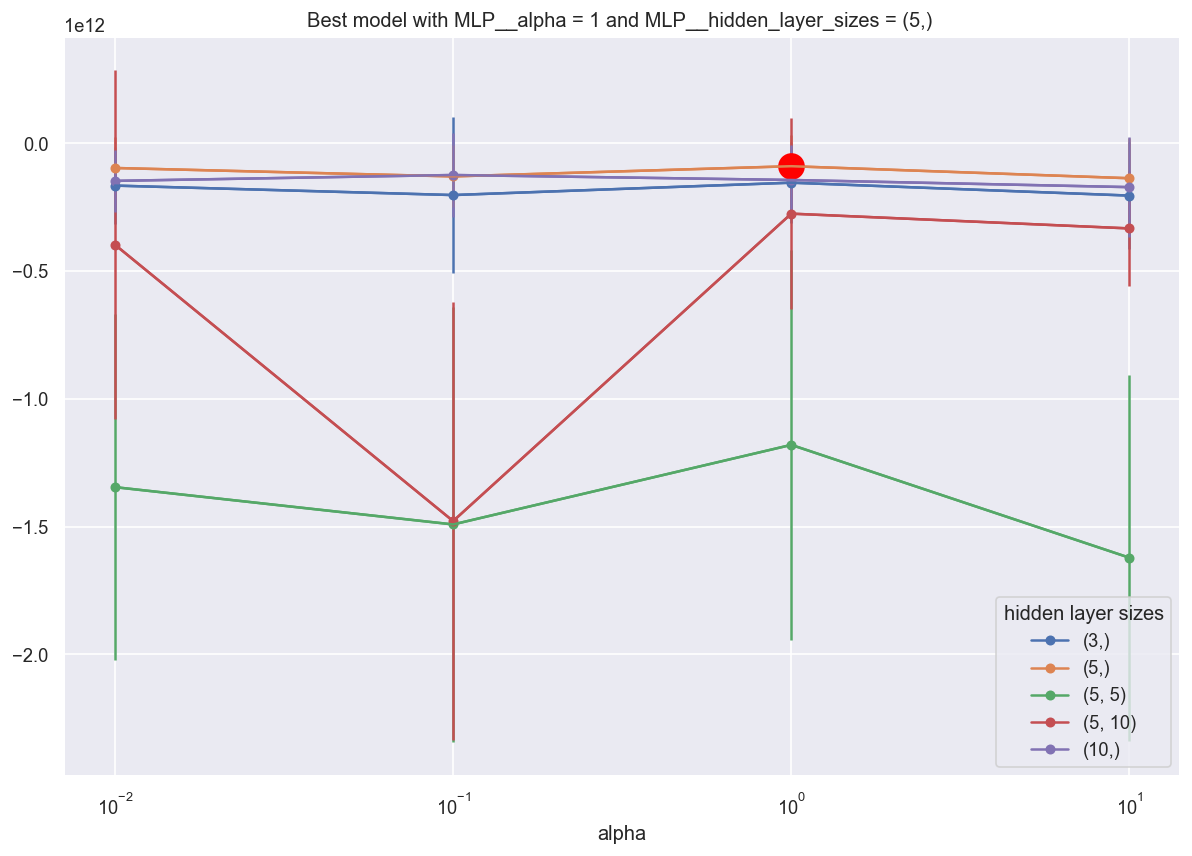

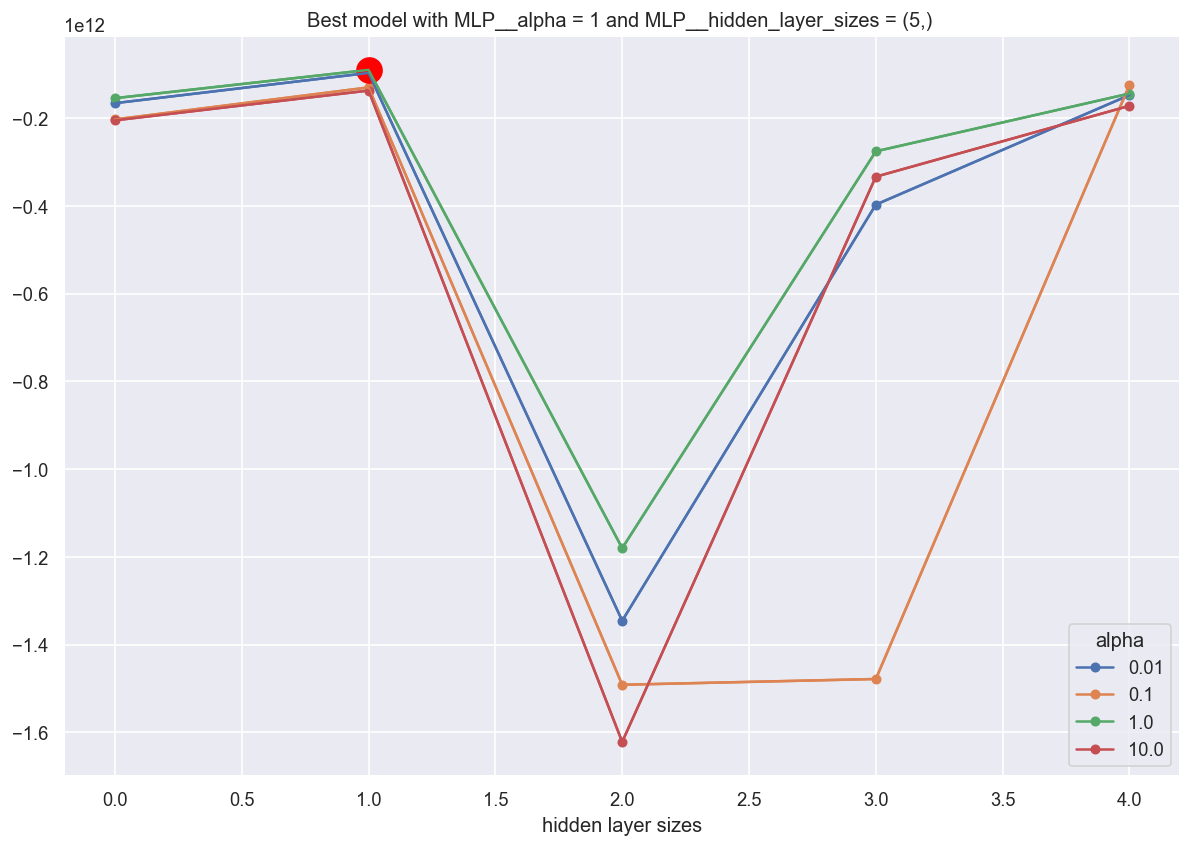

In [230]:
# Plot the cross validation score in the Grid Search
MT.plotModelGridError(MLP_fit, xscale="log")

In [231]:
# SENSITIVITY ANALYSIS
mlp = MLP_fit.best_estimator_['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_
actfunc = ['identity',MLP_fit.best_estimator_['MLP'].get_params()['activation'],mlp.out_activation_]
X = MLP_fit.best_estimator_['preprocessor'].transform(X_train) # Preprocess the variables
coefnames = MLP_fit.best_estimator_['preprocessor'].get_feature_names_out(INPUTS_MLP)

X = pd.DataFrame(X, columns=coefnames)
y = pd.DataFrame(y_train, columns=['TOTAL'])
sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True

#Compute sensitivities
sensmlp = ns.jacobian_mlp(wts, bias, actfunc, X, y)
sensmlp.summary()
#sensmlp.info()

Sensitivity analysis of [5, 5, 1] MLP network.

Sensitivity measures of each output:

$TOTAL 

                         mean           std  mean_squared
num__TOTAL_lag1  97137.297217  1.251526e+06  1.255290e+06
num__TOTAL_lag2  79332.514256  1.022128e+06  1.025202e+06
num__TOTAL_lag3  81968.172680  1.056086e+06  1.059262e+06
num__TOTAL_lag4  44649.736608  5.752715e+05  5.770016e+05
num__TOTAL_lag5  37244.939221  4.798674e+05  4.813106e+05


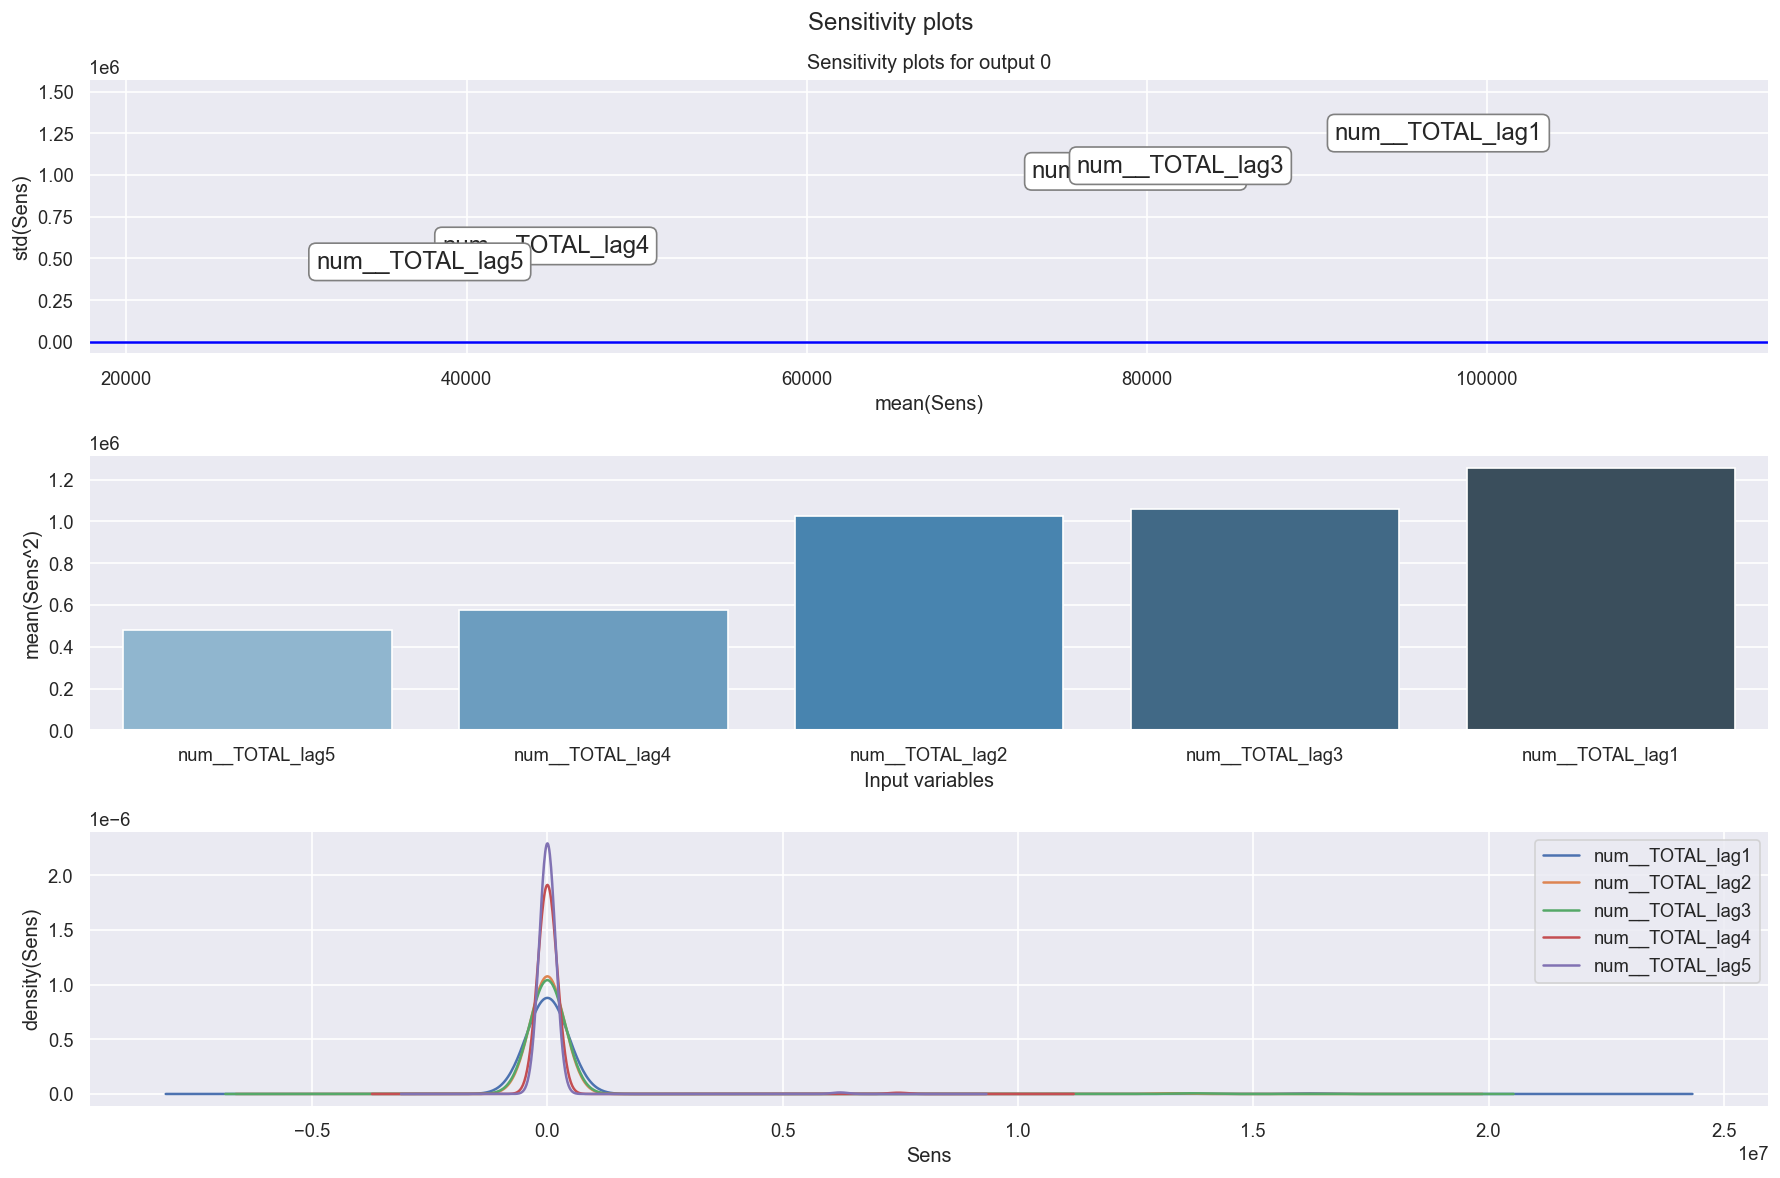

In [232]:
sensmlp.plot()

In [233]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['MLP_pred'] = MLP_fit.predict(X_train)
### Scale test using preprocess in training
dfTS_eval['MLP_pred'] = MLP_fit.predict(X_test)

#Training and test MAE - Mean Absolute error
print('Training MAE:',mean_absolute_error(dfTR_eval['TOTAL'], dfTR_eval['MLP_pred']))
print('Test MAE:',mean_absolute_error(dfTS_eval['TOTAL'], dfTS_eval['MLP_pred']))
#Training and test RMSE - Root Mean Square Error
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval['TOTAL'], dfTR_eval['MLP_pred'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['TOTAL'], dfTS_eval['MLP_pred'])))
#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval['TOTAL'], dfTR_eval['MLP_pred']))
print('Test R2:',r2_score(dfTS_eval['TOTAL'], dfTS_eval['MLP_pred']))

Training MAE: 231633.00751960778
Test MAE: 823719.5718561502
Training RMSE: 327163.0128437924
Test RMSE: 870418.6551533348
Training R2: 0.9184093565992402
Test R2: -8.57633176087321


In [ ]:
### Plot predictions of the model
sns.scatterplot(x='TOTAL_lag1', y='TOTAL', data=dfTR_eval, color='black', alpha=0.5)
sns.scatterplot(x='TOTAL_lag1', y='MLP_pred', data=dfTR_eval, color='red', edgecolor='black').set_title('Predictions for training data')
plt.show()
plt.figure() # Needed to plot two separated plots instead of two overlapped
sns.scatterplot(x='TOTAL_lag1', y='TOTAL', data=dfTS_eval, color='black', alpha=0.5)
sns.scatterplot(x='TOTAL_lag1', y='MLP_pred', data=dfTS_eval, color='red', edgecolor='black').set_title('Predictions for training data')
plt.show()

In [ ]:
#Analysis of residuals
RT.plotModelDiagnosis(dfTR_eval, 'MLP_pred', 'TOTAL',figsize=[15,15])

In [ ]:
# Visualize prediction with respect to output
sns.scatterplot(data=dfTS_eval, x='TOTAL', y='TOTAL', color='black', alpha=0.5)
sns.scatterplot(data=dfTS_eval, x='MLP_pred', y='TOTAL', color='blue', edgecolor='black')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Check correlation of residuals
FT.ts_display(dfTS_eval['TOTAL'] - dfTS_eval['MLP_pred'])